<a href="https://colab.research.google.com/github/Cruiz118/Public_Procurement_Navarra_11_23/blob/main/TFM_An%C3%A1lisis_y_modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importamos los siguientes paquetes para la carga y tratamiento de datos
import os
import glob
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


# Warnings
import warnings
warnings.filterwarnings("ignore")

# Importamos las librerías de análisis y visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy as sp
import statsmodels.api as sm
from scipy import stats
import re
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
# Formato print
pd.options.display.float_format = '{:,.2f}'.format
# Guardamos
plot_pdf = True

# Importamos las librerías relaciondas con la modelización y preprocesado de datos
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

# Métricas de resultados
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

# Modelos
!pip install -q catboost
!pip install -q xgboost
!pip install -q lightgbm
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, SGDRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Guardar y cargar un modelo
from joblib import dump, load

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00


In [ ]:
# Conversión a HTML
#!jupyter nbconvert --execute --to html "/content/drive/MyDrive/TFM/Trabajo/TFM - Análisis y modelado.ipynb"

<a name="top"></a>
# 1. PRESENTACIÓN



<a name="item1.1"></a>
## 1.1 Motivación

La contratación pública es uno de los ejes estratégicos de cualquier Administración eficaz y eficiente. Su importancia es doble debido a dos características intrínsecas a cualquier proceso de licitación:

* Por un lado, las entidades públicas necesitan prestar una serie de servicios y realizar una serie de actuaciones para las que no está capacitada, por lo que deben acudir al mercado para poder cubrirlas.

* Por otro, estas prestaciones a contratar tienen una importancia cada vez mayor a nivel presupuestario, condicionando en gran medida las actuaciones que pueden llevar a cabo los entes públicos.

Diversos [informes](https://www.cnmc.es/ambitos-de-actuacion/promocion-de-la-competencia/contratacion-publica) de entidades independientes estiman que la contratación pública supera el 10% del PIB nacional , superando los 125 mil millones de [euros](https://www.administracionpublicadigital.es/proyectos/2024/02/el-gasto-publico-en-licitaciones-crece-un-17-en-2023-y-supera-los-125000-millones-de-euros.) En respuesta a esto, la comunidad científica actual está cada vez más interesada en aportar soluciones en esta área, con recientes investigaciones en el campo del Machine Learning que están dando prometedores resultados .


<a name="item1.2"></a>
## 1.2 Objetivo

El objetivo de este trabajo es crear un estimador de los precios de adjudicación de los contratos públicos de la Comunidad Foral de Navarra, herramienta que puede ayudar en la elaboración de presupuestos más exactos y realistas, así como coadyuvar al ahorro de las arcas públicas. Para este trabajo nos hemos basado en la investigación de [Manuel J. García Rodríguez](https://digibuo.uniovi.es/dspace/handle/10651/63675?show=full).

Nuestro trabajo consistirá en elaborar un modelo de regresión de los precios de adjudicación, es decir:

* Variable objetivo (y): será la variable _importe de adjudicación_.
* Variables predictoras (X): resto de variables de nuestro dataset.

<a name="item2"></a>
# 2. PREPROCESADO DE DATOS

<a name="item2.1"></a>
## 2.1 Carga de datos

Los datos con los que vamos a trabajar son públicos y están disponibles a través del [Portal de Transparencia de Navarra](https://datosabiertos.navarra.es/es/dataset/registro-de-contratos).

El periodo de nuestro análisis abarca 10 años, del ejercicio 2013 al 2023.

In [ ]:
#Damos acceso a los archivos de Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Lista de todos los archivos CSV en la carpeta
archivos_csv = glob.glob('/content/drive/MyDrive/TFM/Datos/CSV/*.csv')
# Lee y concatena los archivos de la carpeta en un solo DF
dataset = pd.concat([pd.read_csv(archivo, encoding= 'utf-8') for archivo in archivos_csv])
# Veamos nuestro dataset
print("El número de filas de nuestro dataset es de {}".format(len(dataset)))
print("El número de columnas de nuestro dataset es de {}".format(len(dataset.columns)))
print("Por tanto, el tamaño de nuestro dataset es de {}".format(dataset.size))

El número de filas de nuestro dataset es de 27667
El número de columnas de nuestro dataset es de 34
Por tanto, el tamaño de nuestro dataset es de 940678


Vemos que el dataset contiene un total de 27.667 filas y 34 columnas en las que se contiene la información relativa a las licitaciones llevadas a cabo en la Comunidad Foral de Navarra en los últimos 10 años.

Obtengamos un vistazo general de las filas y columnas de nuestra base de datos.

<a name="item2.1"></a>
## 2.2 Análisis exploratorio inicial

Uno de los grandes retos de este proyecto ha consistido en limpiar y manipular los inputs iniciales hasta obtener un dataset íntegro y consistente. En este sentido, el principal problema residía en el **elevado número de campos vacíos** del dataset inicial.

Utilizando ```Missingno```,librería especializada en la detección y análisis de datos nulos, puede vislumbrarse la dimensión del problema:

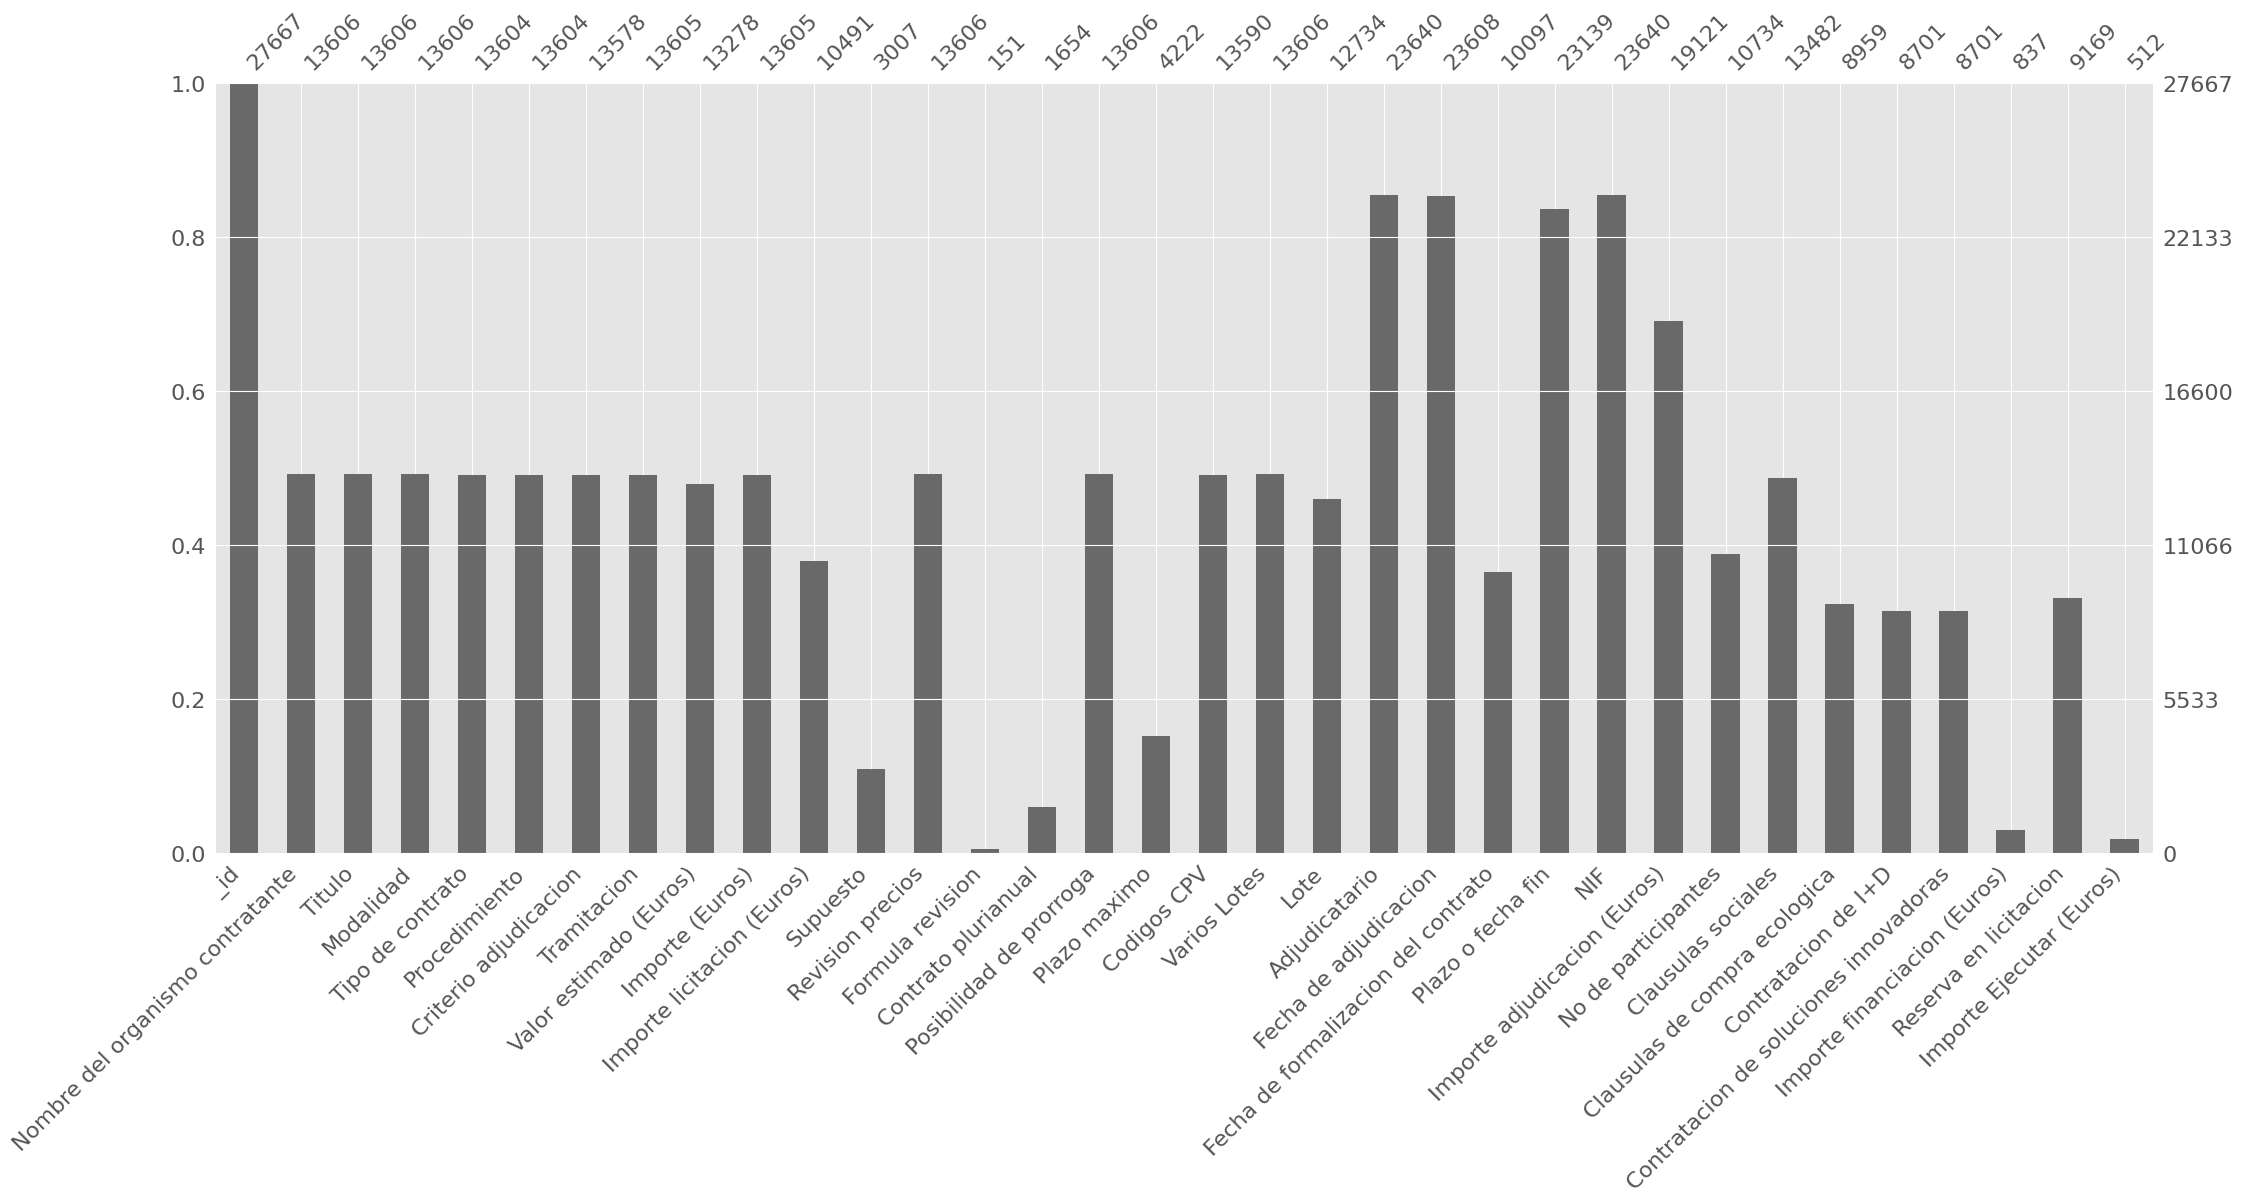

In [ ]:
import missingno as msno
# Tamaño
plt.figure(figsize=(4,4))
# Gráfico de barras
msno.bar(dataset)
plt.show()

Cuando en un procedimiento de licitación existen varios [lotes](#item1.3) la forma en la que esto queda registrado es muy **problemática**.

Basicamente, en lugar de salir una única línea por cada licitación (que sería lo correcto) lo que se genera es una primera línea con gran parte de los datos que son generales de esa licitación (entidad adjudicataria, tipo de contrato, nº de participantes, etc.) y luego una serie de líneas que están practicamente vacías y que recogen información concreta de esos lotes en los que está dividida.

Como podemos observar, casi todas los columnas tienen más de un 50% de los campos vacíos. La parte inicial de este proyecto ha consistido en **obtener un dataset que integre en la medida de lo posible esta información y que finalmente tenga una línea por cada procedimiento de licitación**.

Dado que esta parte del tratamiento y preprocesado de datos ha sido muy extensa vamos a adjuntarla en el **Anexo I** como parte de la documentación asociada a este trabajo.

Sin embargo, a efectos de comparar cuál era el estado inicial de dataset y cuál es su estado final vamos a utilizar la siguiente **función** creada con este fin:


In [ ]:
def estado_df(df):
    # Creamos un diccionario para almacenar los resultados de cada campo
    resultados = {'nulos': [], 'completo': [], 'porcentaje': []}

    # Iteramos sobre las columnas del DataFrame
    for columna in df.columns:
        # Contamos los valores nulos (en blanco) en la columna
        nulos = df[columna].isnull().sum()
        # Contamos los valores no nulos (completos) en la columna
        completos = df[columna].notnull().sum()
        #Obtenemos el porcentaje
        porcentaje_nulos = round((nulos / len(df)) * 100,2)


        # Agregar los resultados al diccionario
        resultados['nulos'].append(nulos)
        resultados['completo'].append(completos)
        resultados['porcentaje'].append(porcentaje_nulos)

    # Crear un nuevo DataFrame a partir del diccionario
    df_completos = pd.DataFrame(resultados, index=df.columns)

    # Mostrar el DataFrame resultante
    print(df_completos) # Indent this line

<a name="item2.2.1"></a>
### 2.2.1 Comparación datos iniciales con datos procesados

* **Dataset inicial**

El estado inicial de nuestro dataset era el siguiente.

In [ ]:
# Dimensión
dataset.shape

(27667, 34)

In [ ]:
# Columnas y valores nulos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27667 entries, 0 to 972
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   _id                                     27667 non-null  int64  
 1   Nombre del organismo contratante        13606 non-null  object 
 2   Titulo                                  13606 non-null  object 
 3   Modalidad                               13606 non-null  object 
 4   Tipo de contrato                        13604 non-null  object 
 5   Procedimiento                           13604 non-null  object 
 6   Criterio adjudicacion                   13578 non-null  object 
 7   Tramitacion                             13605 non-null  object 
 8   Valor estimado (Euros)                  13278 non-null  object 
 9   Importe (Euros)                         13605 non-null  object 
 10  Importe licitacion (Euros)              10491 non-null  object 
 

El trabajo realizado ha consistido en:

1. Creación de las columnas 'no_de_lotes' y 'no_de_adjudicatarios'.
2. Obtención de un dataset con una línea por proceso de licitación.
3. Unificación de los datos de duración.
4. Creación de las columnas 'tpo_entidad'
5. Reducción de la dimensionalidad con la eliminación de columnas con datos erróneos o innecesarios.
6. Detección y eliminación de outliers.

Para un análisis detallado de las transformaciones y filtrados utilizados se recomienda revisar el **Anexo I**.

* **Dataset final**

Los **datos procesados** son los siguientes.

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/TFM/Datos/df_preprocesado.xlsx',
                   dtype= {
                       'adjudicador':'category',
                       'tipo_contrato':'category',
                       'criterio_adjudicacion':'category',
                       'procedimiento': 'category',
                       'tramitacion':'category',
                       'cod_cpv':'category',
                       'subcod_cpv_fe':'category',
                       'tipo_entidad_fe':'category'
                   })

In [ ]:
# Dimensión de nuestro dataset
df.shape

(10812, 22)

In [ ]:
# Estado tras el preprocesado de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10812 entries, 0 to 10811
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   adjudicador              10812 non-null  category
 1   tipo_contrato            10812 non-null  category
 2   procedimiento            10812 non-null  category
 3   criterio_adjudicacion    10812 non-null  category
 4   tramitacion              10812 non-null  category
 5   valor_estimado           10812 non-null  float64 
 6   importe_adj              10812 non-null  float64 
 7   importe_estimado         10812 non-null  float64 
 8   rev_precios              10812 non-null  bool    
 9   plurianual               10812 non-null  bool    
 10  prorroga                 10812 non-null  bool    
 11  cod_cpv                  10796 non-null  category
 12  tiene_lote               10812 non-null  bool    
 13  no_ofertas               9121 non-null   float64 
 14  no_de_

In [ ]:
# Visualizamos el dataset
df.head(3)

,adjudicador,tipo_contrato,procedimiento,criterio_adjudicacion,tramitacion,valor_estimado,importe_adj,importe_estimado,rev_precios,plurianual,...,tiene_lote,no_ofertas,no_de_lotes_fe,no_de_adjudicatarios_fe,duracion_fe,año_fe,mes_fe,dia_fe,tipo_entidad_fe,subcod_cpv_fe
0,agencia navarra dependencia,obras,abierto,cualitativo,ordinaria,"480,950.36","363,598.47","418,217.70",False,False,...,False,5.00,1,1,419.75,"2,023.00",1.00,16.00,organismo autonomo,45
1,agencia navarra dependencia,servicios,abierto,cualitativo,ordinaria,"622,618.67","100,146.12","101,656.36",False,False,...,False,1.00,1,1,"1,800.00","2,023.00",2.00,14.00,organismo autonomo,98
2,agencia navarra dependencia,suministro,procedimiento simplificado,cualitativo,ordinaria,"29,250.00","22,231.26","29,250.00",False,False,...,True,2.00,4,1,365.00,"2,023.00",5.00,8.00,organismo autonomo,39


Como puede observarse, los datos han quedado reducidos a menos de la mitad de lo que inicialmente teníanmos y se han eliminado 11 características que no son necesarias para nuestro modelado posterior.

<a name="item2.3"></a>
## 2.3 Breve explicación de las variables de nuestro dataset

El número de características con las que vamos a trabajar finalmente son 22. Muchas de ellas provienen del dataset original, pero otras han sido creadas a partir de la información existente o con información externa que puede ser de utilidad para nuestro modelo.

Las variables _originalmente_ presentes en nuestro dataset son las siguientes:

* **Adjudicador**: entidad contratante encargada de gestionar el procedimiento de licitación.
* **tipo_contrato**: Tipo de contrato que se está licitando.
* **procedimiento**: Tipo de procedimiento que se está siguiendo.
* **criterio_adjudicación**: Criterio que se está siguiendo para determinar la mejor oferta.
* **tramitacion**: trámite que se está siguiendo. Principalmente se utiliza para distinguir si es de urgencia o no.
* **valor_estimado**: Coste estimado total del contrato durante todo su ciclo de vida. Se considera principalmente su duración total.
* **importe_estimado**: coste estimado del contrato para una anualidad.
* **importe_adj**: importe por el que ha sido adjudicado el contrato. Es nuestra variable objetivo  (y).
* **rev_precios, plurianual, prorroga, tiene_lote**: variables booleanas. Indican si el contrato es susceptible de que se revisen sus precios, de prórrogas, si es plurianual o si está dividido en lotes.
* **cod_cpv**: código que indica la tipología del contrato a nivel europeo.
* **no_ofertas**: indica el número de ofertas que se han presentado a esa licitación.

Las variables creadas en el proceso de _feature engineering_ son:
* **no_de_lotes_fe**: recoge el número de lotes en los que se divide ese contrato. Cada lote puede ser adjudicado a una empresa (adjudicatario) distinto.
* **no_de_adjudicatarios_fe**: número de adjudicatarios que ha tenido un contrato.
* **duracion_fe**: duración estimada del contrato.
* **año_fe, mes_fe, dia_fe**: desglose de la fecha de adjudicación.
* **tipo_entidad_fe**: tipo de entidad adjudicadora contratante. Pueden ser ayuntamientos, departamentos del gobierno, empresas públicas, etc.
* **subcod_cpv_fe**: código que indica el _sector_ al que pertenece el contrato según la normativa europea. Se compone de los dos primeros dígitos del 'cod_cpv'.

# 3. ANÁLISIS ESTADÍSTICO Y DETECCIÓN DE OUTLIERS

## 3.1 Análisis EDA variables numéricas

Nuestro dataset cuenta con las siguientes variables de naturaleza numérica.

In [ ]:
df.select_dtypes(include = ['float','int']).columns

Index(['valor_estimado', 'importe_adj', 'importe_estimado', 'no_ofertas',
       'no_de_lotes_fe', 'no_de_adjudicatarios_fe', 'duracion_fe', 'año_fe',
       'mes_fe', 'dia_fe'],
      dtype='object')

Tenemos tres variables relacionadas con el __importe__ de los contratos, otras tres relacionadas con la __concurrencia de empresas__ a esa licitación y otras tres de carácter __temporal__. Sobre estas resulta esencial aclarar los siguientes aspectos:

> _¿Qué tipo de distribución siguen?_

>_¿Existe algún tipo de relación entre las mismas?_

Comencemos analizando la información básica.

In [ ]:
# Aplicamos el método describe con los valores redondeados a dos dígitos

df[['valor_estimado','importe_adj','importe_estimado','no_ofertas','no_de_lotes_fe','no_de_adjudicatarios_fe','duracion_fe']].describe().applymap(lambda x: f'{x:.0f}')

,valor_estimado,importe_adj,importe_estimado,no_ofertas,no_de_lotes_fe,no_de_adjudicatarios_fe,duracion_fe
count,10812,10812,10812,9121,10812,10812,10809
mean,487012,251836,288291,3,2,1,599
std,1580860,725905,813870,3,3,1,513
min,180,180,180,0,1,1,-84
25%,39499,26049,29958,1,1,1,365
50%,90760,59900,69026,2,1,1,365
75%,264608,158269,183000,4,1,1,609
max,52076214,9255813,9653048,48,164,26,1825


En las variables relativas a los **importes** se intuye una gran dispersión de los datos. Con un valor mínimo de 180 euros y unos máximos que llegan a los casi 10M de euros. La desviación estándar es muy elevada.

En las variables relativas a la **concurrencia** ocurre un hecho similar; la mayor parte de los valores son muy bajos pero existen unos cuantos outliers muy elevados.

En las variables **temporales** la dispersión no es tan elevada, aunque dada la naturaleza de las mismas esto nos aporta tanta información.

Vistos los resultados, parece improbable que ninguna de nuestras variables cumpla con las características de una **distribución normal**. Ayudémonos de los siguientes histogramas para comprobarlo.

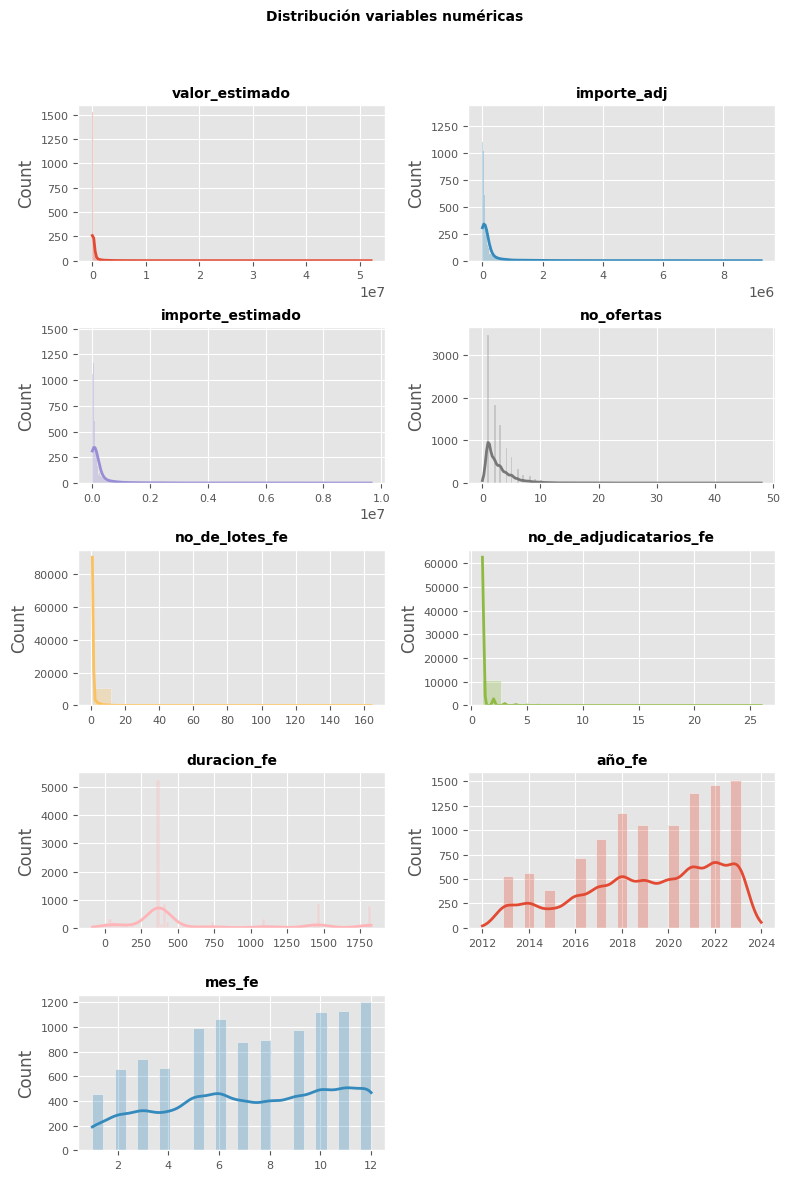

In [ ]:
# Ajustamos el número de subplots
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (8,12))
axes = axes.flat
columns_numeric = df.select_dtypes(include=['float64','int64']).columns

for i, colum in enumerate(columns_numeric):
  sns.histplot(data = df,
               x = colum,
               stat = 'count',
               kde = True,
               color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
               line_kws= {'linewidth': 2},
               alpha   = 0.3,
               ax = axes[i]
               )
  axes[i].set_title(colum, fontsize = 10, fontweight = 'bold')
  axes[i].tick_params(labelsize = 8)
  axes[i].set_xlabel('')

fig.tight_layout()
fig.delaxes(axes[9])
plt.subplots_adjust(top = 0.9)
# Fondo gris claro
plt.rcParams['axes.facecolor'] = '#f0f0f0'
# Eliminar líneas de grid
plt.rcParams['axes.grid'] = False
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold")
plt.savefig('distribucion_num.pdf');

Existe una **gran dispersión** en las variables numéricas de nuestro dataset, sin que ninguna de ellas cumpla las condiciones de normalidad a primera vista.
Todas las distribuciones se ve que tienen la cola **alargada a la derecha**(asimetría positiva) debido al efecto de varios valores extremos que afectan a la distribución.

En nuestra modelización deberemos tener esto cuenta, ya que dependiendo del algoritmo que utilicemos puede afectar a sus resultados.

Por último, veamos las posibles relaciones que pueda haber entre las variables.

<Figure size 600x600 with 0 Axes>

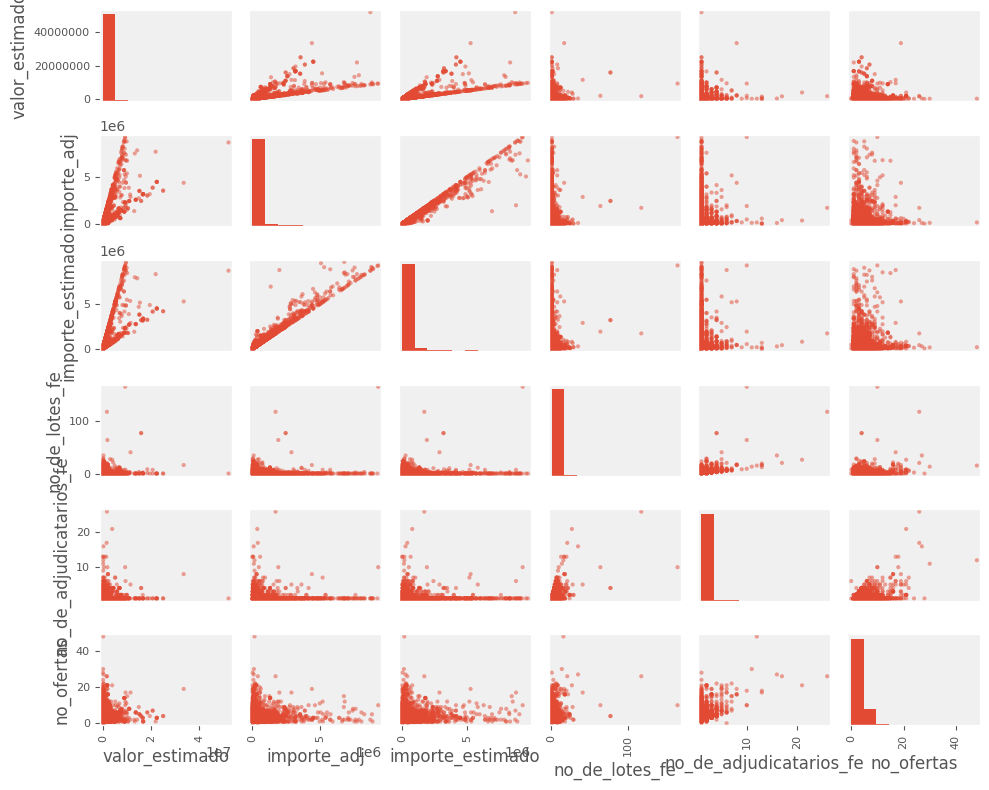

In [ ]:
# Usamos pandas.plotting.scatter_matrix
plt.figure(figsize=(6,6))
pd.plotting.scatter_matrix(df[['valor_estimado',
                                   'importe_adj',
                                   'importe_estimado',
                                   'no_de_lotes_fe',
                                   'no_de_adjudicatarios_fe',
                                   'no_ofertas']],
                           figsize=(10,8))
plt.tight_layout() # Ajusta el espaciado
# Fondo gris claro
plt.rcParams['axes.facecolor'] = '#f0f0f0'
# Eliminar líneas de grid
plt.rcParams['axes.grid'] = False
plt.show()

Se observa una relación potencialmente directa y positiva entre las variables de **importes**, especialmente entre el importe estimado y el importe de adjudicación.

En el resto de variables esta relación se no es tan clara. Quizá observemos una ligera relación entre las variables 'no_de_adjudicadores_fe' y 'no_de_lotes_fe', pero en cualquier caso no parece una relación fuerte.

### 3.1.1 Importe estimado e importe de adjudicación

Vamos a pasar a analizar en mayor profundidad la relación entre las variables 'importe_estimado' e 'importe_adj'. Como hemos explicado, la primera es el presupuesto/gasto anual que una entidad pública prevé gastar en el año, mientras que la segunda es el importe anual por el que ese contrato ha sido finalmente adjudicado a un licitador.

Es decir, la primera es la estimación y la segunda es el **coste final** que se ha acordado.

Dentro de nuestro dataset hemos incluido valores extremos que no hemos considerado errores, es por ello que al realizar el análisis de la normalidad salía una cola tan alargada.

Sin embargo, en el análisis actual vamos a limitar los valores a un nivel en el que los outliers no afecten tanto a nuestra visualización y podamos detectar algún patrón.

El umbral utilizando para la selección de los datos será 3.5 veces la mediana del 'importe estimado'.

In [ ]:
umbral = np.median(df['importe_estimado'])*3.5

In [ ]:
# Limitamos nuestro df al importe que estimemos
df_plot = df[(df['importe_estimado']<=umbral)]

* **Scatter plot**

Nuestro modelo parte de que existe una relación muy clara entre las variables 'importe estimado' y el 'importe de adjudicación'. Veamos si esto es así:

<Figure size 500x400 with 0 Axes>

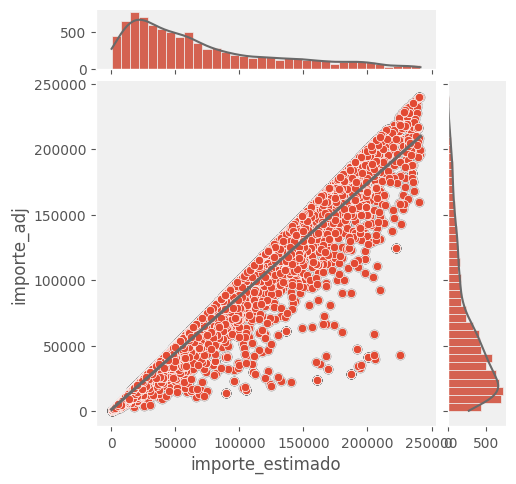

In [ ]:
# Gráfico de dispersión con la distribución de frecuencias
plt.figure(figsize=(5,4))
ax = sns.jointplot(data = df_plot,
                   x = 'importe_estimado',
                   y = 'importe_adj',
                   color = 'dimgray',
                   kind = 'reg',
                   marginal_ticks = True,
                   height = 5)
ax.plot(sns.scatterplot, sns.histplot)

Se observa una relación **directa y positiva** entre ambas variables.

Así mismo, cabe puntualizar los siguientes puntos:

* Observamos una línea clara formada por las observaciones en torno al _eje de los 45º_. Este es el punto donde el importe estimado **es igual** al importe de adjudicación. Por lo tanto, se trata de un punto donde no hay desviación alguna entre el importe presupuestado y el final (no hay error).

* Por _debajo_ de los 45º encontramos todos aquellos casos en los que el importe de adjudicación ha sido menor. Es decir, hay una desviación respecto al presupuesto inicial, lo que consideraríamos un **error o ahorro** para la Administración.

* Por último, no existen observaciones que estén por _encima del eje_. Esto se debe a que la normativa no permite que el precio de adjudicación supere el de licitación.

¿Cómo podemos solucionar el problema de los outliers? Una posible solución es utilizar el logaritmo de ambas variables de forma que se **normalicen**. En el siguiente gráfico aplicamos dicho criterio sobre todo el dataset.

<Figure size 500x400 with 0 Axes>

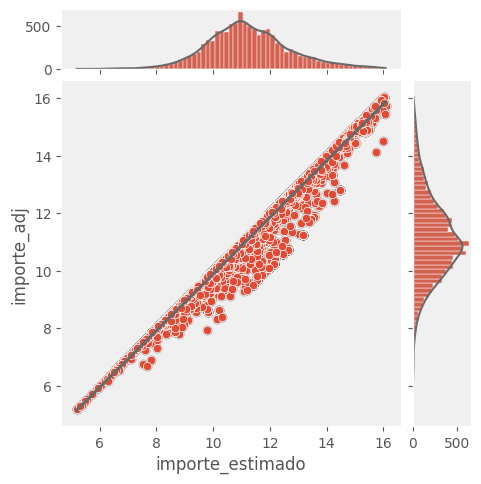

In [ ]:
# Gráfico de dispersión con la distribución de frecuencias
plt.figure(figsize=(5,4))
ax = sns.jointplot(data = df,
                   x = np.log(df['importe_estimado']),
                   y = np.log(df['importe_adj']),
                   color = 'dimgray',
                   kind = 'reg',
                   marginal_ticks = True,
                   height = 5)
ax.plot(sns.scatterplot, sns.histplot)

Como podemos observar la relación lineal y directa queda más clara si cabe y las distribuciones de ambas variables siguen un patrón mucho más normalizado.
Tendremos esta opción presente a la hora de realizar nuestro modelo.

* **Histrograma de frecuencias**

_¿Qué valores son los más repetidos en ambas variables?_

En la siguiente figura tenemos el **histograma** de ambas variables.

La frecuencia consiste en el número de licitaciones por cada 5.000 euros.

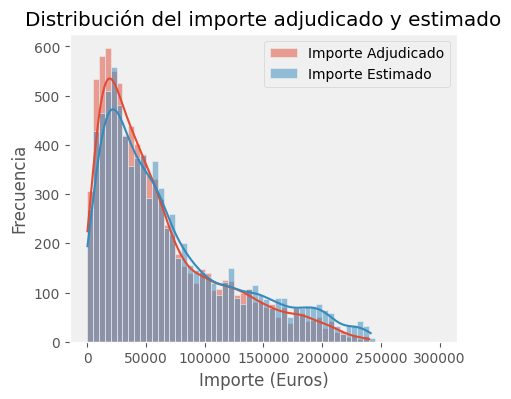

In [ ]:
# Tamaño
plt.figure(figsize=(5,4))
# Definimos los tramos
bins = range(0, 300001, 5000)
# Creamos el histograma
sns.histplot(df_plot, x = 'importe_adj',
             bins = bins,
             palette = 'Blues',
             label = 'Importe Adjudicado',
             kde = True)
sns.histplot(df_plot, x = 'importe_estimado',
             bins = bins,
             palette = 'Reds',
             label = 'Importe Estimado',
             kde = True)

# Detalles
plt.xlabel('Importe (Euros)')
plt.ylabel('Frecuencia')
plt.title('Distribución del importe adjudicado y estimado')
plt.legend()

# Mostramos el gráfico
plt.show()

Como podemos observar, la mayor frecuencia de la variable  _importe adjudicado_ se encuentra concentrada entre los tramos de 5.000-10.000, 10.000-15.000 y 15.000-20.000. Sin embargo, la frecuencia del _importe estimado_ está claramente desplazada a la derecha, ya que los valores son, en general, más elevados.

Como hemos comentado, el importe estimado es un presupuesto inicial planteado por las Adminitraciones Públicas. Uno de los principales objetivos de que los procedimientos de contratación sean públicos es que la **competencia** entre empresas les lleve a hacer ofertas que reduzcan el precio, generando un **ahorro** para las administraciones.

Esto queda patente en el siguiente gráfico, en el que apreciamos que los importes estimados siempre son mayores que los de adjudicación.

**Normalizando** de nuevo el dataset podemos apreciar esta tendencia en general.

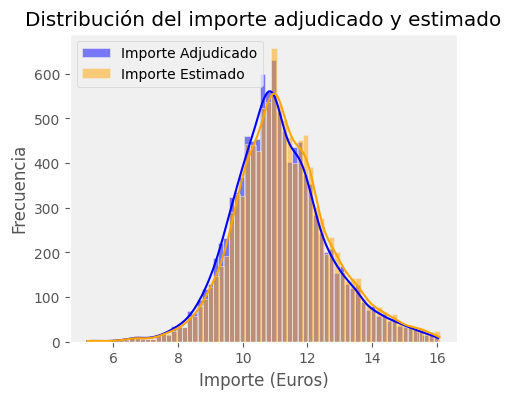

In [ ]:
# Tamaño
plt.figure(figsize=(5,4))
# Creamos el histograma
sns.histplot(df, x = np.log(df['importe_adj']), color = 'blue', label = 'Importe Adjudicado', kde = True)
sns.histplot(df, x = np.log(df['importe_estimado']), color = 'orange', label = 'Importe Estimado', kde = True)

# Detalles
plt.xlabel('Importe (Euros)')
plt.ylabel('Frecuencia')
plt.title('Distribución del importe adjudicado y estimado')
plt.legend()

# Mostramos el gráfico
plt.show()

Sigue apreciándose que en la cola izquierda hay un mayor número de observaciones de la variable 'importe de adjudicación', mientras que en la parte derecha son superiores los del importe estimado. Esto quiere decir que en términos generales el **importe de adjudicación es menor**.

* **Histrograma de errores**

Por último, vamos a analizar **la diferencia en términos absolutos** entre una variable y otra y ver su distribución. Lo que serían las **rebajas** sobre el precio estimado.

Dado que las diferencias son muy elevadas vamos a utilizar el paquete ```plotly```para visualizarlo, de forma que nos permita interactuar con el gráfico y ampliar aquellas áreas de mayor interés.

In [ ]:
# Creamos la variable
df['dif'] = df['importe_estimado'] - df['importe_adj'] # Calculamos 'diferencia' en df_ok
df_plot['dif'] = df_plot['importe_estimado']-df_plot['importe_adj'] # Calculamos 'diferencia' en df_plot

In [ ]:
# La pintamos utilizando plotly express
fig = px.histogram(df_plot,
                   x = 'dif',
                   title = 'Diferencia por tramos',
                   labels = {'x':'Diferencia IEst-IAdj', 'y':'Frecuencia'},
                   text_auto = True,
                   color_discrete_sequence = ['firebrick'],
                   opacity = 0.5)
fig.show()

* **Conclusión de esta fase**

Queda patente la fuerte relación directa y positiva que existe entre nuestra variable objetivo, 'importe_adj', y la variable 'importe_estimado'. Dada la naturaleza de las dos es lógico y será una variable muy valiosa en nuestra modelización posterior.

### 3.1.2 Resto de variables numéricas

Veamos si existe algún tipo de relación entre el resto de variables numéricas.
Para ello utilizaremos ```pairplot``` de la librería ```seaborn```.

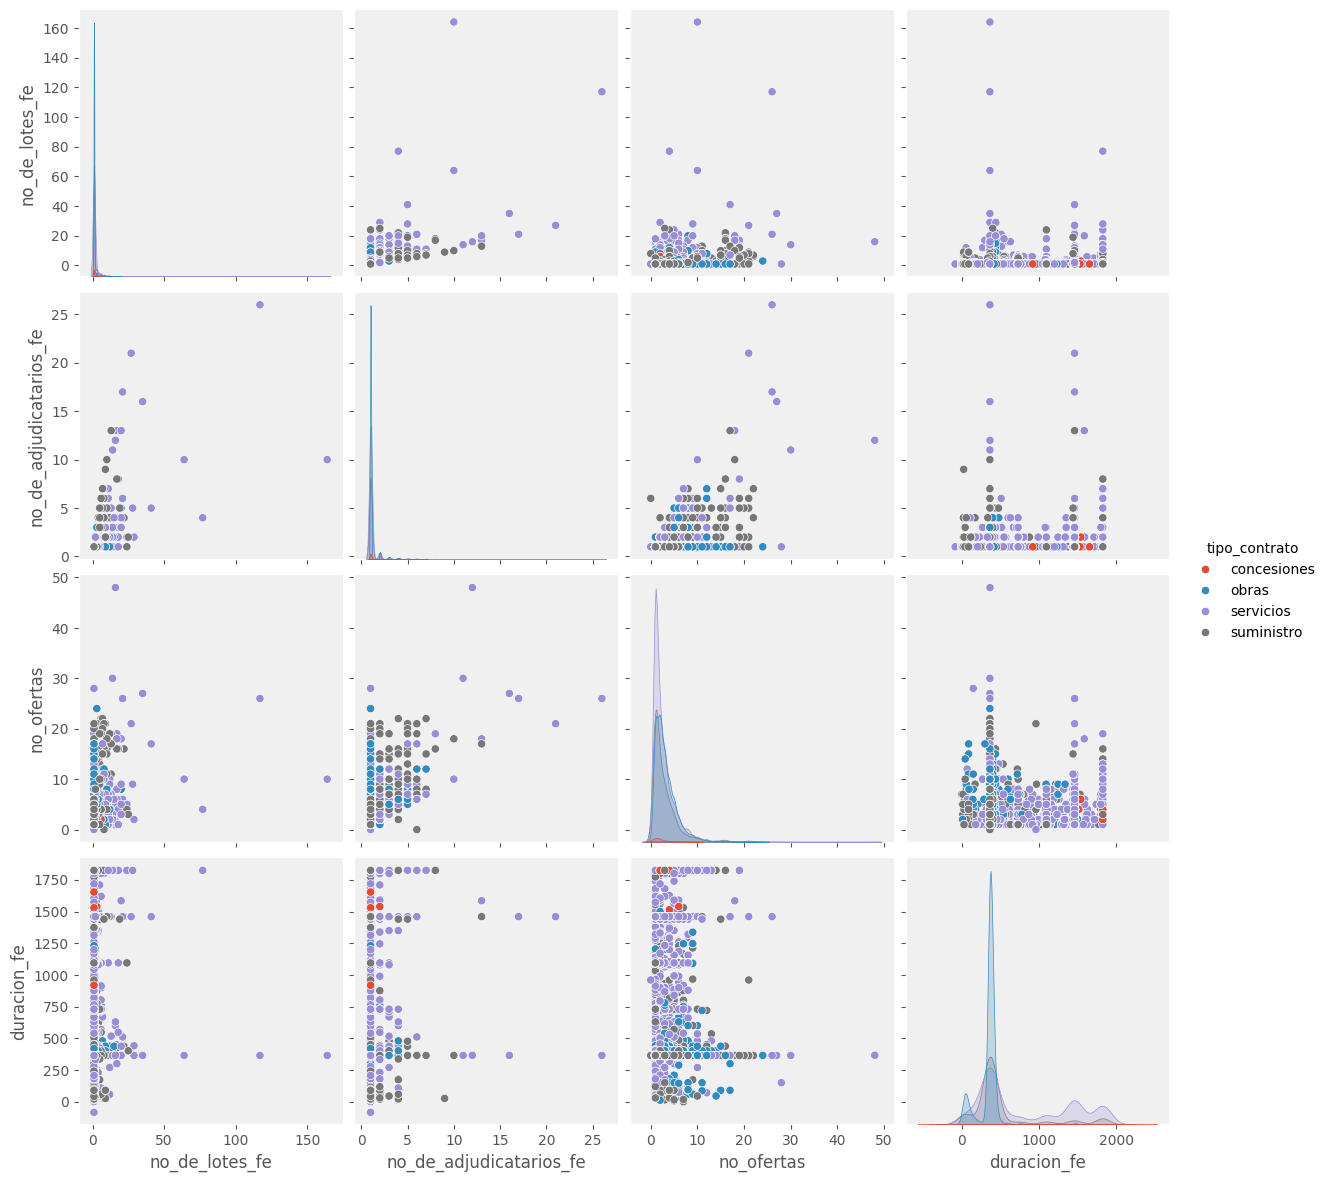

In [ ]:
# Pintamos el gráfico
sns.pairplot(df,
             vars = ['no_de_lotes_fe','no_de_adjudicatarios_fe','no_ofertas','duracion_fe'],
             hue = 'tipo_contrato',
             height = 3)

Volvemos a obsevar una ligera relación entre las características relativas al número de ofertas, de lotes y de adjudicatarios.

Observemos en mayor profundidad la relación existente entre estas.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Creamos la figura
plt.figure(figsize=(6,6))
fig = px.scatter_3d(df,
                    x = 'no_ofertas',
                    y = 'no_de_lotes_fe',
                    z = 'no_de_adjudicatarios_fe',
                    opacity = 0.5,
                    color='no_ofertas',
                    size='no_de_lotes_fe',
                    hover_name='no_de_adjudicatarios_fe')

# Mostramos la figura
fig.show()


<Figure size 600x600 with 0 Axes>

Parece que puede existir cierta relación positiva.

Lo que está sesgando los datos son ciertas observaciones con un elevadísimo número de lotes.

Vamos a ver el resultado limitando esto a un máximo de 30 lotes.

In [ ]:
df1= df[df['no_de_lotes_fe'] < 30]
plt.figure(figsize=(6,6))
fig = px.scatter_3d(df1,
                    x = 'no_ofertas',
                    y = 'no_de_lotes_fe',
                    z = 'no_de_adjudicatarios_fe',
                    opacity = 0.5,
                    color='no_ofertas',
                    size='no_de_lotes_fe',
                    hover_name='no_de_adjudicatarios_fe')

# Mostramos la figura
fig.show()


<Figure size 600x600 with 0 Axes>

Intuimos de forma más clara la existencia de una relación positiva entre las variables.

Sin embargo, esta queda muy suavizada por el elevado número de observaciones en las que solamente hay **un adjudicatario**.

### 3.1.3 Matriz de correlación

Realicemos una matriz de correlación con la que observar cuál es la relación existente entre nuestras variables numéricas.

In [ ]:
df.drop(columns=['dif'],inplace=True)

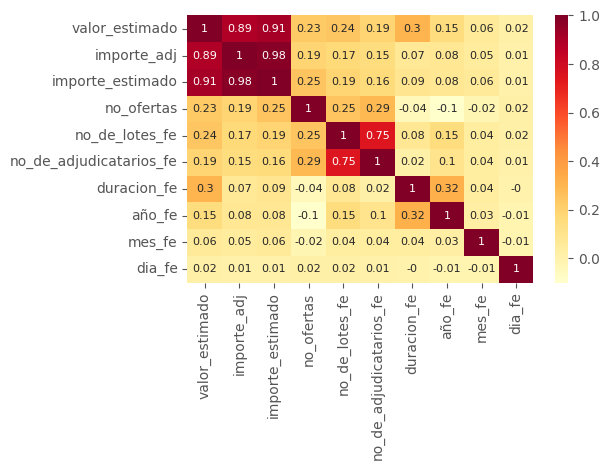

In [ ]:
# Seleccionar solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_columns]

# Calcular la matriz de correlación
corr = df_numeric.corr(method = 'spearman').round(2)

# Graficar la matriz de correlación
sns.heatmap(corr,
            annot=True,
            cmap='YlOrRd',
            annot_kws={"size": 8}) # Adjust the font size of the numbers
plt.tight_layout()
plt.show()

Observamo lo siguiente:
* Existe una fuerte correlación lineal positiva entre la variable objetivo (importe_adj) y la variable 'importe_estimado'.
* Con el resto de variables sigue apreciándose cierta correlación con el número de ofertas y de lotes, aunque esta sea muy leve.
* Con el resto de variables la relación es casi nula.

## 3.2 Análisis EDA variables categóricas

Realicemos ahora nuestro análisis de las variables categóricas.

En este caso, vamos a excluir del análisis las dos variables 'adjudicador' y 'cod_cpv' debido al elevado número de niveles que tienen.

In [ ]:
cols_categoricas = df.select_dtypes(include=['category']).columns.drop(['adjudicador','cod_cpv','subcod_cpv_fe'])
len(cols_categoricas)

5

### 3.2.1 Balanceo de las variables

Empecemos por ver si las distintas categorías están balanceadas.

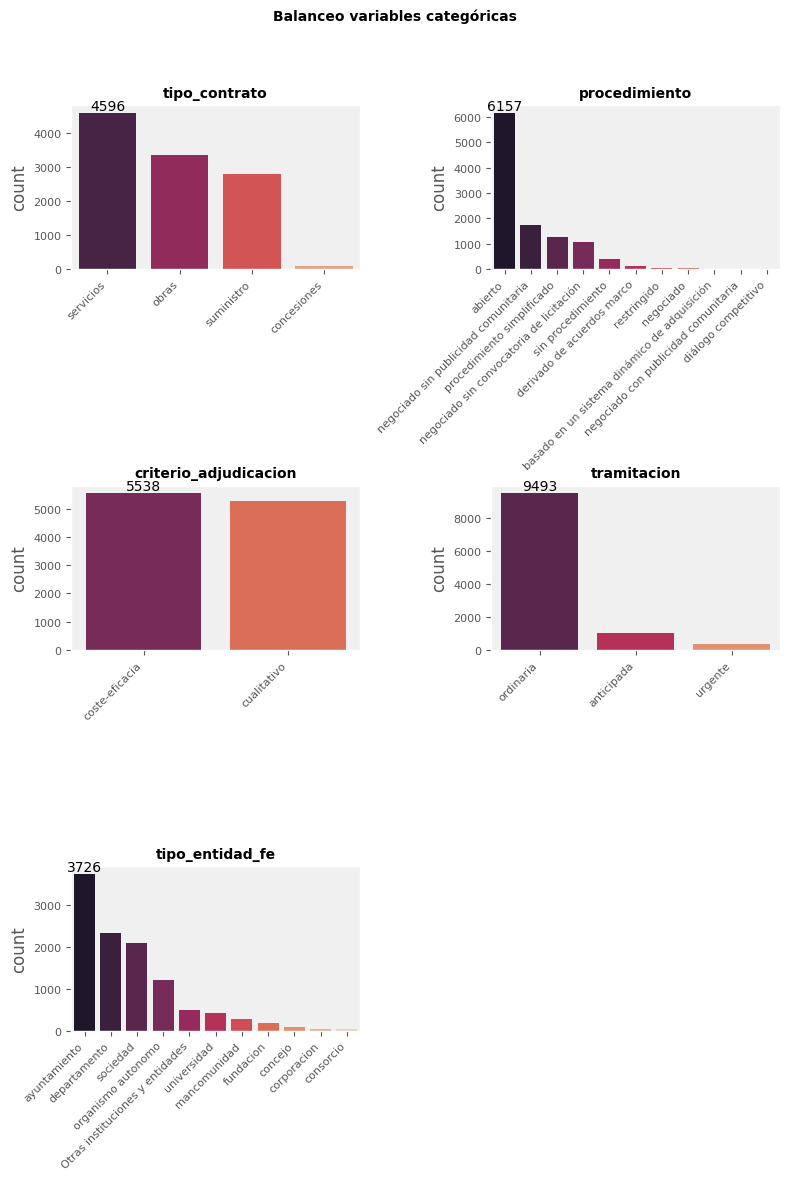

In [ ]:
# Visualización del balanceo de cada variable
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (8,12))
axes = axes.flat

for i, columna in enumerate(cols_categoricas):
  sns.countplot(x=columna,
                data=df,
                palette = 'rocket',
                order = df[columna].value_counts().index,
                ax = axes[i])
  axes[i].set_title(columna, fontsize = 10, fontweight = 'bold')
  axes[i].tick_params(labelsize = 8)
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
  axes[i].set_xlabel('')
  axes[i].bar_label(axes[i].containers[0])

fig.delaxes(axes[5])
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Balanceo variables categóricas', fontsize = 10, fontweight = "bold")
plt.savefig('grafico_balanceo.pdf');

Vamos a tratar de balancear aquellos valores que son menos frecuentes para las variables 'procdimiento', 'tramitacion' y 'tipo_entidad_fe'.

In [ ]:
def balanceo(df, columna):
  total = df[columna].count()
  valor = df[columna].value_counts()
  for i in range(len(valor)):
    if (valor[i]/total)<0.1:
      df[columna] = df[columna].replace(valor.index[i],'Otros')
  return df[columna]

In [ ]:
# Lo aplicamos a nuestras variables desbalanceadas
df['procedimiento'] = balanceo(df,'procedimiento')
df['tramitacion'] = balanceo(df,'tramitacion')
df['tipo_entidad_fe'] = balanceo(df,'tipo_entidad_fe')

### 3.2.2 Boxplot

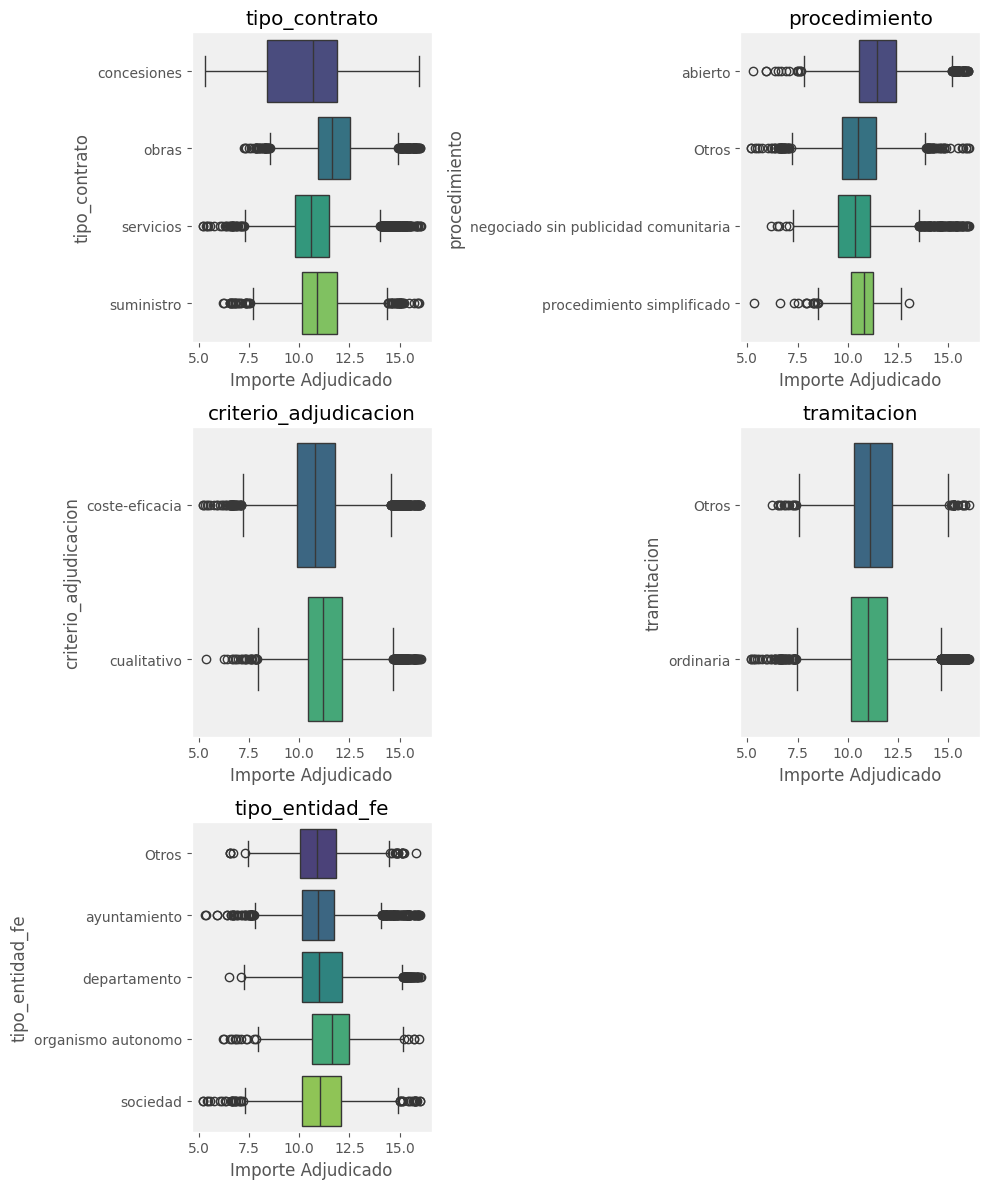

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()
for i, col in enumerate(cols_categoricas):
    sns.boxplot(data=df,
                x=np.log(df["importe_adj"]),
                y=col,
                palette = 'viridis',
                ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Importe Adjudicado')
    axes[i].set_ylabel(col)
fig.delaxes(axes[5])
plt.tight_layout()
plt.savefig('grafico_boxplot_cat.pdf')
plt.show();

### 3.2.3 Subcódigo CPV (Common Procurement Vocabulary)

La categoría _sector_ nos ofrece un nivel de desagregación adecuado para analizar el efecto que cada tipo de contrato puede tener sobre los importes de adjudicación.

Vamos a crear de forma manual la variable _MAPE_, con la que podremos medir el nivel de desviación que hay en el importe de adjudicación respecto al estimado por tipología de contrato.

In [ ]:
df['MAPE'] = -(df['importe_adj']-df['importe_estimado'])/df['importe_adj']*100

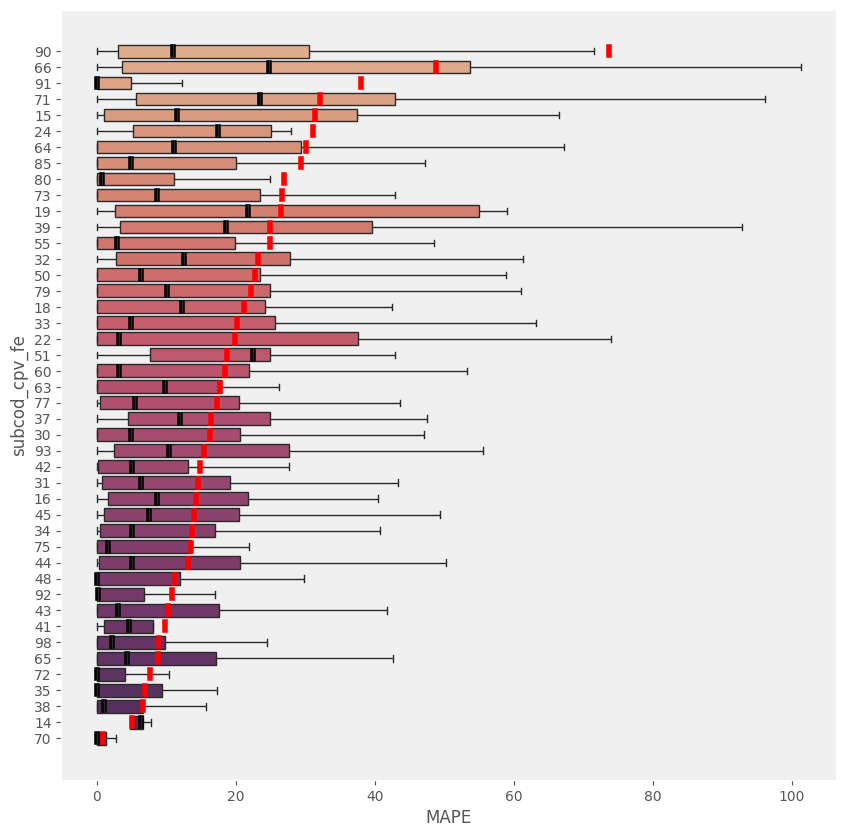

In [ ]:
# Tamaño
plt.figure(figsize=(10,10))
# Filtramos los NaN
df_filtered = df[df['subcod_cpv_fe'] != 'na']

# Calculamos la media del MAPE para cada 'subcod_cpv_fe' y ordenamos
mean_mape = df_filtered.groupby('subcod_cpv_fe')['MAPE'].mean().sort_values(ascending=False)

# Creamos un boxplot ordenado por el eje y, sin outliers y sin NaN
ax = sns.boxplot(x=df_filtered['MAPE'],  # Filtrado
            y=df_filtered['subcod_cpv_fe'],
            data=df_filtered,
            palette='flare',
            order=mean_mape.index,
            showfliers=False)

# Calculamos la media y la mediana para cada grupo
for i, subcod in enumerate(mean_mape.index):
    # Creamos variables
    media_cpv = df_filtered[df_filtered['subcod_cpv_fe'] == subcod]['MAPE'].mean()
    mediana_cpv = df_filtered[df_filtered['subcod_cpv_fe'] == subcod]['MAPE'].median()

    # Dibuja la línea de la media
    ax.plot([media_cpv, media_cpv], [i - 0.25, i + 0.25], color='red', linewidth=4, label='MAPE') # Changed label to MAPE

    # Dibuja la línea de la mediana
    ax.plot([mediana_cpv, mediana_cpv], [i - 0.25, i + 0.25], color='black', linewidth=4, label='MdAPE') # Changed label to MdAPE

plt.savefig('grafico_MAPE_subcod.pdf')
plt.show();

## 3.3 Análisis competencia

¿ Existe alguna relación entre el nivel de competencia de una licitación y el precio de adjudicación?

La teoría básica detrás de las licitaciones públicas sustenta que a mayor concurrencia de una licitación mejor es la solución que se acaba adoptando y a un mejor precio.

Veamos si los datos nos dan algún atisbo de esta tendencia.

In [ ]:
# Creamos la variable 'diferencia'
# ==============================================================================
df['dif'] = df['importe_estimado'] - df['importe_adj']

In [ ]:
# Creamos la variable 'nivel_competencia'
# ==============================================================================
def nivel_competencia(df):
  # Creamos una lista vacía
  nivel_competencia = []
  # Iterate over each 'no_ofertas' value in the DataFrame
  for ofertas in df['no_ofertas']:
    if ofertas <= 1:
      nivel_competencia.append('Sin competencia')
    elif ofertas <= 4:
      nivel_competencia.append('Baja')
    elif ofertas <= 10:
      nivel_competencia.append('Media')
    else:
      nivel_competencia.append('Alta')
  # Asignamos a la nueva columna
  df['nivel_competencia'] = nivel_competencia
  return df

# Aplicamos la función
nivel_competencia(df)

# La categorizamos
df['nivel_competencia'] = df['nivel_competencia'].astype('category')

Creada la variable, vamos a utilizarla para agrupar los datos y contrastar si existe algún tipo de tendencia en los importes estimados y de adjudicación final.

In [ ]:
# Creamos un nuevo DF
df_competencia = df.groupby('nivel_competencia').agg(
    count=('no_ofertas', 'count'),
    adjudicador=('adjudicador', 'nunique'),  # Use 'adjudicador'
    ofertas =('no_ofertas','mean'),
    media_iestimado=('importe_estimado','mean'),
    mediana_iestimado=('importe_estimado','median'),
    media_iadj=('importe_adj','mean'),
    mediana_iadj=('importe_adj','median'),
    Error_medio=('dif','mean'),
    Error_mediano=('dif','median'),
    MAPE = ('MAPE','mean'),
    MdAPE = ('MAPE','median'),
).sort_values('ofertas', ascending=True)

# Trasponemos
df_competencia.transpose().round(0)

nivel_competencia,Sin competencia,Baja,Media,Alta
count,"3,481.00","4,002.00","1,469.00",169.00
adjudicador,269.00,320.00,210.00,191.00
ofertas,1.00,3.00,6.00,15.00
media_iestimado,"160,315.00","252,458.00","429,878.00","493,074.00"
mediana_iestimado,"51,000.00","76,128.00","128,886.00","61,035.00"
media_iadj,"149,337.00","224,444.00","361,015.00","416,371.00"
mediana_iadj,"48,000.00","65,225.00","91,013.00","55,481.00"
Error_medio,"10,978.00","28,014.00","68,862.00","76,703.00"
Error_mediano,10.00,"6,223.00","18,730.00","1,608.00"
MAPE,9.00,20.00,48.00,16.00


# 4. MODELIZACION

Vamos a proceder a la elaboración de nuestro modelo.

Para ello, vamos a partir de la premisa planteada anteriormente, y es que,

*¿es el importe/precio estimado un estimador adecuado del precio final de adjudicación?*

Venimos de observar una fuerte relación directa y positiva entre ambas variables. Sin embargo, existen otros diversos factores que pueden provocar una bajada de precio considerable.

En principio, todas aquellas variables que aumenten la competencia deberían ir de la mano de una bajada del precio y, por lo tanto, un ahorro respecto al presupuesto inicial.

Este apartado de modelización lo vamos a plantear siguiendo estas premisas de la siguiente manera:
1. En primer lugar, calcularemos cuáles son los resultados obtenidos utilizando la variable 'importe estimado' (X) como predictora de nuestra variable objetivo 'importe de adjudicación'(y). Utilizaremos métricas para medir tanto la exactitud como la varianza de los resultados obtenidos.

2. Esos resultados los compararemos con diversos modelos que tienen en cuenta el resto de variables de nuestro dataset y, entre ellos, elegiremos los más prometedores, para comprobar cuál de todos ofrece los mejores resultados.

3. Por último, trataremos de elaborar una red neuronal con la que intentaremos 'captar' esas relaciones no lineales que pueden estar afectando a nuestro precio final de adjudicación.

**Métricas de error**

La métricas que vamos a utilizar para evaluar nuestro modelo son las siguientes:

* **MAE (Mean Absolut Error)**: Promedio de los errores absolutos. Indica, en promedio, cuánto se desvía mi predicción del valor real. Esta métrica es adecuada en caso de que queramos ignorar los outliers.

* **MAPE (Mean Absolute Percentage Error)**: Promedio del porcentaje de error absoluto. Indica el porcentaje promedio de desviación en las predicciones realizadas.

* **MdAE (Median Absolute Error)**: Mediana de los errores absolutos.

* **MdAPE (Median Absolute Percentage Error)**: Mediana del porcentaje de error absoluto.

* **MSE (Mean Squared Error)**: Promedio de los errores al cuadrado. Penaliza más los errores grandes. No es fácilmente interpretable en su escala original.

* **RMSE (Root Mean Squared Error)**: Raíz cuadrada del MSE. Tiene las mismas unidades que la variable objetivo y es fácilmente interpretable. Indica el desvío promedio de cada predicción respecto al valor real.

**Métricas de ajuste**
* **R² (R-squared)**: Indica la proporción de la varianza de la variable objetivo que es explicada por el modelo. Adquiere un valor entre 0-1, teniendo un mejor rendimiento cuanto más se ajuste al 1.

## 4.1 DF y Funciones para modelización

* **Modelo**

Vamos a eliminar aquellas variables que no son necesarias para el modelo.

In [ ]:
# Eliminamos las variables innecearias
df.drop(columns=['valor_estimado','MAPE','dif','nivel_competencia'], inplace=True)

In [ ]:
# Copia del dataset para utilizarlo en el modelado
df_model = df.copy()

In [ ]:
# Copia en la que vamos a aplicar el logaritmo de las variables 'importe_estimado' e 'importe_adj'
df_model_log = df.copy()
df_model_log['importe_estimado'] = np.log(df_model_log['importe_estimado'])
df_model_log['importe_adj'] = np.log(df_model_log['importe_adj'])

In [ ]:
# Estado actual de nuestro modelo
estado_df(df_model)

                         nulos  completo  porcentaje
adjudicador                  0     10812        0.00
tipo_contrato                0     10812        0.00
procedimiento                0     10812        0.00
criterio_adjudicacion        0     10812        0.00
tramitacion                  0     10812        0.00
importe_adj                  0     10812        0.00
importe_estimado             0     10812        0.00
rev_precios                  0     10812        0.00
plurianual                   0     10812        0.00
prorroga                     0     10812        0.00
cod_cpv                     16     10796        0.15
tiene_lote                   0     10812        0.00
no_ofertas                1691      9121       15.64
no_de_lotes_fe               0     10812        0.00
no_de_adjudicatarios_fe      0     10812        0.00
duracion_fe                  3     10809        0.03
año_fe                      36     10776        0.33
mes_fe                      36     10776      

* **Funciones de resultados**

In [ ]:
def evaluar_modelo(modelo, X_test, y_true):
  """
  Evalúa el rendimiento de un modelo de regresión.

  Args:
    modelo: El modelo de regresión entrenado.
    X_test: Los datos de prueba.
    y_true: Los valores reales de la variable objetivo.

  Returns:
    Un diccionario con las métricas de evaluación.
  """
  y_predicted = modelo.predict(X_test)

    # Calcula Absolute Percentage Error (APE)
  ape = np.abs((y_true - y_predicted) / y_true) * 100

    # Cálculo del mean absolute error
  mae = round(mean_absolute_error(y_true, y_predicted),2)

  # Calcula Mean Absolute Percentage Error (MAPE)
  mape = np.round(np.mean(ape),2)

  # Cálculo del median absolute error
  mdae = round(median_absolute_error(y_true, y_predicted),2)

  # Calcula Median Absolute Percentage Error (MdAPE)
  mdape = np.round(np.median(ape), 2)

  # Cálculo del MSE
  rmse = round(mean_squared_error(y_true, y_predicted, squared=False),2)

  # Cálculo del R²
  r2 = round(r2_score(y_true, y_predicted),2)

  return {
      'MAE': mae,
      'MAPE':mape,
      'MdAE':mdae,
      'MdAPE':mdape,
      'RMSE': rmse,
      'R²': r2
  }

In [ ]:
def evaluar_modelo_norm(modelo, X_test, y_true):
  """
  Evalúa el rendimiento de un modelo de regresión.

  Args:
    modelo: El modelo de regresión entrenado.
    X_test: Los datos de prueba.
    y_true: Los valores reales de la variable objetivo.

  Returns:
    Un diccionario con las métricas de evaluación.
  """
  y_predicted_log = modelo.predict(X_test)
  y_predicted = np.exp(y_predicted_log)

  y_true = np.exp(y_true)

    # Calcula Absolute Percentage Error (APE)
  ape = np.abs((y_true - y_predicted) / y_true) * 100

  # Calcula Mean Absolute Percentage Error (MAPE)
  mape = np.round(np.mean(ape),2)

  # Calcula Median Absolute Percentage Error (MdAPE)
  mdape = np.round(np.median(ape), 2)

  # Calcular el Mean Absolute Percentage Error (MdAE)
  mdae = np.round(np.mean(ape))

  # Cálculo del MSE
  rmse = round(mean_squared_error(y_true, y_predicted, squared=False),2)

  # Cálculo del median absolute error
  mdae = round(median_absolute_error(y_true, y_predicted),2)

  # Cálculo del mean absolute error
  mae = round(mean_absolute_error(y_true, y_predicted),2)

  # Cálculo del R²
  r2 = round(r2_score(y_true, y_predicted),2)

  return {
      'MAE': mae,
      'MAPE':mape,
      'MdAE':mdae,
      'MdAPE':mdape,
      'RMSE': rmse,
      'R²': r2
  }

In [ ]:
def evaluar_modelo_con_cv(modelo, X, y, cv):
  """
  Evalúa el rendimiento de un modelo de regresión usando cross-validation.

  Args:
    modelo: El modelo de regresión a evaluar.
    X: Los datos de entrada.
    y: Los valores reales de la variable objetivo.
    cv: El número de pliegues para cross-validation.

  Returns:
    Un diccionario con las métricas de evaluación promedio obtenidas con cross-validation.
  """

  # Definimos funciones para calcular las métricas que no están predefinidas en scikit-learn
  def mape_scorer(y_true, y_predicted):
    ape = (np.abs((y_true - y_predicted) / y_true) * 100)
    return np.mean(ape)

  def mdae_scorer(y_true, y_predicted):
    return np.median(np.abs(y_true - y_predicted))

  def mdape_scorer(y_true, y_predicted):
    ape = (np.abs((y_true - y_predicted) / y_true) * 100)
    return np.median(ape)

  # Creamos scorers personalizados usando make_scorer
  # Nota: greater_is_better=False para métricas de error
  mape_scorer = make_scorer(mape_scorer, greater_is_better=False)
  mdae_scorer = make_scorer(mdae_scorer, greater_is_better=False)
  mdape_scorer = make_scorer(mdape_scorer, greater_is_better=False)

  # Calculamos las métricas de evaluación usando cross-validation
  mse_scores = cross_val_score(modelo, X, y, cv=cv, scoring='neg_mean_squared_error')
  rmse_scores = np.sqrt(-mse_scores)
  mae_scores = cross_val_score(modelo, X, y, cv=cv, scoring='neg_mean_absolute_error')
  r2_scores = cross_val_score(modelo, X, y, cv=cv, scoring='r2')
  mape_scores = cross_val_score(modelo, X, y, cv=cv, scoring=mape_scorer)
  mdae_scores = cross_val_score(modelo, X, y, cv=cv, scoring=mdae_scorer)
  mdape_scores = cross_val_score(modelo, X, y, cv=cv, scoring=mdape_scorer)

  # Calculamos las métricas promedio
  mse_mean = round(-mse_scores.mean(), 2)
  rmse_mean = round(rmse_scores.mean(), 2)
  mae_mean = round(-mae_scores.mean(), 2)
  r2_mean = round(r2_scores.mean(), 2)
  mape_mean = round(-mape_scores.mean(), 2)
  mdae_mean = round(-mdae_scores.mean(), 2)
  mdape_mean = round(-mdape_scores.mean(), 2)

  return {
      'MAE': mae_mean,
      'MAPE': mape_mean,
      'MdAE':mdae_mean,
      'MdAPE':mdape_mean,
      'MSE': mse_mean,
      'RMSE': rmse_mean,
      'R²': r2_mean
  }

In [ ]:
def evaluar_modelo_cv(modelo, X, y, cv):
    """Evalúa un modelo utilizando validación cruzada y devuelve métricas en la escala original."""
    resultados = {}

    # Calculamos las predicciones usando validación cruzada
    y_pred = cross_val_predict(modelo, X, y, cv=cv)

    # Convertimos las predicciones y valores reales a la escala original
    y_pred_original = np.exp(y_pred)
    y_original = np.exp(y)

    # Calculamos las métricas en la escala original
    resultados['MAE'] = round(mean_absolute_error(y_original, y_pred_original),2)

    # Calculamos MAPE
    ape = np.abs((y_original - y_pred_original) / y_original) * 100
    resultados['MAPE'] = round(np.mean(ape), 2) # Agregamos MAPE

    resultados['MdAE'] = round(median_absolute_error(y_original, y_pred_original),2)

    # Calculamos MdAPE
    resultados['MdAPE'] = round(np.median(ape), 2) # Agregamos MdAPE

    resultados['MSE'] = round(mean_squared_error(y_original, y_pred_original),2)
    resultados['RMSE'] = round(np.sqrt(resultados['MSE']),2)
    resultados['R²'] = round(r2_score(y_original, y_pred_original),2)

    return resultados

In [ ]:
def graficar_resultados(y_true, y_predicted, resultados):
  """
  Crea un gráfico de dispersión de valores reales vs. predichos con Seaborn.

  Args:
    y_true: Los valores reales de la variable objetivo.
    y_predicted: Los valores predichos por el modelo.
  """

  plt.figure(figsize=(5, 4))
  sns.scatterplot(x=np.ravel(y_true), y=np.ravel(y_predicted), alpha=0.5)
  plt.xlabel('Valores Reales')
  plt.ylabel('Valores Predichos')
  plt.title('Valores Reales vs. Predichos')
  plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)  # Línea de referencia
  plt.text(0.67, 0.33, resultados, transform=plt.gca().transAxes, fontsize =9,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  plt.show()

def graficar_histograma_errores(y_true, y_predicted):
  """
  Crea un histograma de los errores con Seaborn.

  Args:
    y_true: Los valores reales de la variable objetivo.
    y_predicted: Los valores predichos por el modelo.
  """
  errores = y_true - y_predicted
  plt.figure(figsize=(5, 4))
  sns.histplot(errores, bins=20, kde=True)  # kde=True añade una curva de densidad
  plt.xlabel('Error')
  plt.ylabel('Frecuencia')
  plt.title('Histograma de Errores')
  plt.show()

def graficar_residuos(y_true, y_predicted):
  """
  Crea un gráfico de residuos con Seaborn.

  Args:
    y_true: Los valores reales de la variable objetivo.
    y_predicted: Los valores predichos por el modelo.
  """
  residuos = y_true - y_predicted
  plt.figure(figsize=(5, 4))
  sns.residplot(x=y_predicted,
                y=residuos,
                lowess=True,
                scatter_kws={'alpha': 0.5})  # lowess=True añade una curva de suavizado
  plt.xlabel('Valores Predichos')
  plt.ylabel('Residuos')
  plt.title('Gráfico de Residuos')
  plt.axhline(y=0, color='k', linestyle='--', lw=2)  # Línea de referencia
  plt.show()

* **Curva de aprendizaje y validación**

In [ ]:
def curvasAprendizaje(X_train,y_train, pipeline):
    train_sizes, train_scores, test_scores =\
                                learning_curve(estimator=pipeline,
                                X=X_train,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(7, 6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o',
             markersize=5, label='Datos de entrenamiento')
    plt.fill_between(train_sizes, train_mean + train_std,
                     train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='red', marker='o',
             markersize=5, label='Datos de prueba')
    plt.fill_between(train_sizes, test_mean + test_std,
                     test_mean - test_std, alpha=0.15, color='red')
    plt.title('Curvas de Aprendizaje')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('R2')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [ ]:
def curvaValidacion(estimator, X, y, param_name, param_range, cv, scoring):
    """
    Visualización de la curva de validación de un estimador.

    Args:
        estimator: El objeto estimador de sklearn.
        X: Datos de entrenamiento.
        y: Variable objetivo.
        param_name: El nombre del parámetro a variar.
        param_range: Rango de valores para el parámetro.
        cv: Número de folds de la cv.
        scoring: Métrica de ajuste.
    """

    train_scores, test_scores = validation_curve(
        estimator,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring=scoring,
        n_jobs=-1  # Utiliza todos los núcleos disponibles
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(7, 6))
    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(param_range, test_mean, color='red', marker='o', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='red')

    plt.title('Validation Curve')
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

## 4.2 Modelo simple: Linear Regression

Comenzamos con la evaluación de la variable _importe estimado_ (X) como variable predictora de nuestra variable objetivo _importe de adjudicación_ (y). Como hemos comentado utilizaremos la modelización más simple de todas, ```LinearRegression()```.



### **4.2.1 División train y test**

In [ ]:
X_lr = df_model_log['importe_estimado'].values.reshape(-1,1)
y_lr = df_model_log['importe_adj'].values.reshape(-1,1)
X_train, X_test, y_train, y_test  = train_test_split(X_lr, y_lr, test_size=0.2, random_state=1)

### **4.2.2 Entrenamiento y resultados del modelo**

In [ ]:
# Guardamos el modelo
lr = LinearRegression()

In [ ]:
# Entrenamos el modelo
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
evaluar_modelo(lr, X_test, y_test)

{'MAE': 0.15,
 'MAPE': 1.36,
 'MdAE': 0.11,
 'MdAPE': 1.09,
 'RMSE': 0.26,
 'R²': 0.97}

#### Resultados con Cross- Validation

Para asegurar la robustez de nuestro resultados vamos a utilizar la técnica del Cross-Validation, mediante la cual nuestro conjunto de test se divide en distintas partes (folds) y los resultados finales son la media de todos los que se han calculado.

In [ ]:
evaluar_modelo_cv(lr, X_train, y_train,5)

{'MAE': 37114.14,
 'MAPE': 17.12,
 'MdAE': 5973.1,
 'MdAPE': 10.81,
 'MSE': 23388963188.6,
 'RMSE': 152934.51,
 'R²': 0.96}

In [ ]:
evaluar_modelo_cv(lr, X_test, y_test,5)

{'MAE': 37449.9,
 'MAPE': 19.23,
 'MdAE': 6321.56,
 'MdAPE': 11.25,
 'MSE': 17505030463.73,
 'RMSE': 132306.58,
 'R²': 0.96}

Como podemos observar, los resultados obtenidos reflejan un coeficiente de determinación **(R2) del 96%**. Es decir, que un 96% de la varianza de nuestra variable objetivo quedaría explicada con este modelo.

Sin embargo, existen otra serie de métricas con las que medir la **exactitud de nuestro modelo** en la que no hemos obtenido un resultado tan bueno como el esperado:

* El MAE es de más de 37.164 euros (un 17,5%).
* El MdAE de superior a los 6.075 euros un (10,9%) respecto a la variable original.
* El Error Estándar de los Residuos (RMSE) es de 149.060 euros.

¿Es nuestro modelo **significativo**? Comprobémoslo con el F-test.

In [ ]:
from scipy.stats import f_oneway

f_oneway(X_lr, y_lr)

F_onewayResult(statistic=array([47.11132362]), pvalue=array([6.88821406e-12]))

Queda patente que nuestro predictor tiene importancia para el modelo que hemos realizado.

#### **Predicciones del modelo**

Veamos cómo se ajustan los valores predichos (y_pred) a los reales (y_test).

Guardamos los resultados en diversas variables.

In [ ]:
mae, mape, mdae, mdape, mse, rmse, r2 = evaluar_modelo_cv(lr, X_lr, y_lr,5).values()
resultados = '\n'.join((
    r'$R^2 = %.2f$' % (r2, ),
    r'MAE = %.2f' % (mae, ),
    r'MAPE = %.2f' % (mape, ),
    r'MdAE = %.2f' % (mdae, ),
    r'MdAPE = %.2f' % (mdape, ),
    r'RMSE = %.2f' % (rmse, )
    ))
residuals = y_test - lr.predict(X_test)

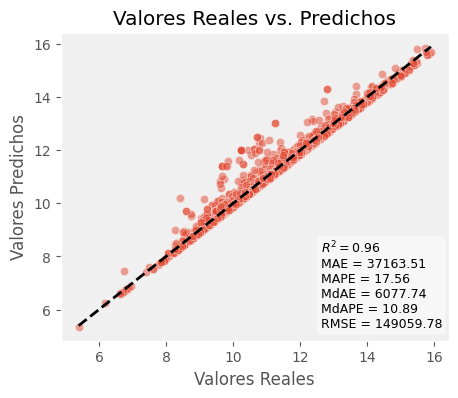

In [ ]:
graficar_resultados(y_test, lr.predict(X_test), resultados)

Como puede observarse, parece que la capacidad de predicción del modelo es buena.

Sin embargo, queda asegurarnos de una pieza fundamental en los modelos de Regresión Lineal: **si nuestro modelo cumple con las hipótesis estadísticas necesarias**.

### **4.2.3 Cumplimiento de los supuestos del modelo**

#### **No colinealidad o multiconileadidad**

En los modelos múltiples los predictores deben ser independientes, no debe haber colinealidad entre ellos. Si la hubiera esto provocaría que no se pudiera determinar de forma correcta el efecto individual de cada predictor sobre la variable objetivo, lo que se traduce en un aumento de la varianza de los coeficientes de regresión y, en última instancia, en la imposibilidad de establecer su significancia estadística.

En nuestro caso únicamente estamos utilizando una variable predictora: el importe estimado. Por lo tanto, cumpliríamos con la supuesto.

#### **Relación lineal entre los predictores numéricos y la variable respuesta**

Cada variable numérica debe estar linealmente relacionada con la variable objetivo $y$, de lo contrario no debiera introducirse en el modelo.

La forma más recomendable de comprobarlo es analizando los residuos del modelo frente a cada uno de los predictores.

_Si la relación es lineal, los residuos debieran distribuirse de forma aleatorio en torno a 0._

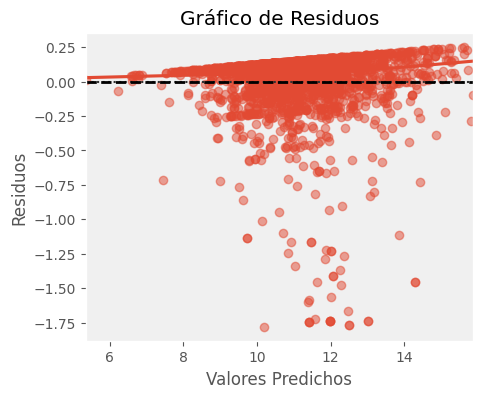

In [ ]:
graficar_residuos(y_test, lr.predict(X_test))

En este caso sí que apreciamos una desviación clara. Es muy probablmente debido a los outliers que afectan a nuestra predicción, y en los que el error es muy elevado.

#### **Normalidad**

La variable respuesta se tiene que distribuir de forma normal. Para comprobarlo se recurre a histogramas, a los cuantiles normales o a test de hipótesis de normalidad.

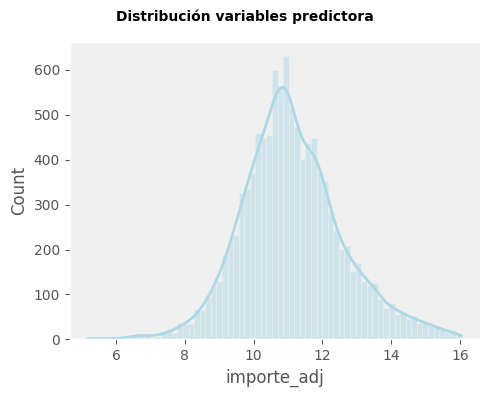

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
# columnas_numericas = data_model.select_dtypes(include=['float64','int']).columns
# Graficamos el histograma
sns.histplot(data = df_model_log,
              x = df_model_log['importe_adj'],
              stat = 'count',
              kde = True,
              color = 'lightblue',
              line_kws = {'linewidth':2},
              alpha = 0.5)
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables predictora', fontsize = 10, fontweight = "bold");

A primera vista, parece que la variable predictora cumple con la hipótesis de normalidad.

Vemos los valores de asimetría y kurtosis. Si los valores se encuentran en el -1 y 1 pueden considerarse que la desviación es ligera.

In [ ]:
import statsmodels.api as sm
from scipy import stats

print('Kurtosis: ', stats.kurtosis(df_model_log['importe_adj']))
print('Skewness: ', stats.skew(df_model_log['importe_adj']))

Kurtosis:  0.651417081679937
Skewness:  0.32444285682928076


Parecen encontrarse en ese rango.

Por último, realizaremos los test _Shapiro-Wilk_ test y _D'Agostino's K-squared_ test son dos de los test de hipótesis más empleados.

In [ ]:
shapiro_test = stats.shapiro(df_model_log['importe_adj'])
print("Prueba de Shapiro-Wilk: p-value =", shapiro_test.pvalue)

Prueba de Shapiro-Wilk: p-value = 7.740051065406207e-30


El test Shapiro-Wilk parece que **rechaza** la H0 de normalidad. Sin embargo, se recomienda no usar este test en muestras superiores a 50 observaciones, ya que es muy sensible a outliers.

En su lugar, veamos que resultado arroja el test _D'Agostino's K-squared_.

In [ ]:
k2, p_value = stats.normaltest(df_model_log['importe_adj'])
print(f"Prueba de D'Agostino's K-squared: Estadístico = {k2}, p-value ={p_value}" )

Prueba de D'Agostino's K-squared: Estadístico = 292.9776097916955, p-value =2.4028152140426456e-64


Se sigue **rechazando** la hipóstesis nula de normalidad de la variable predictora.

Por lo tanto, **no se cumple el supuesto de normalidad**.

#### **Homocedasticidad**

La varianza de la variable rspuesta debe ser constante en todo el rango de los predictores. Para comprobarlo, vamos a representar los residuos de nuestro modelo.

El supuesto de homocedasticidad exige que para todo el recorrido de  la variable X la varianza del error sea constante. Esto es importante de cara a la predicción de valores en los cuales la desviación tipo de los residuos forma parte del cálculo del intervalo de confianza.

Si la varianza es constante se dispersaran de forma aleatoria y sin seguir ningún tipo de patrón.

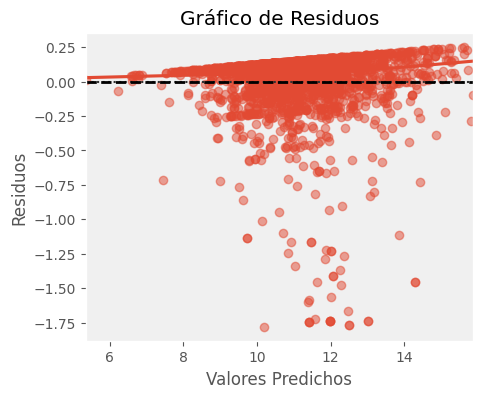

In [ ]:
graficar_residuos(y_test, lr.predict(X_test))

Asimismo, al dibujar los residuos en un histograma obtenemos el siguiente resultado.

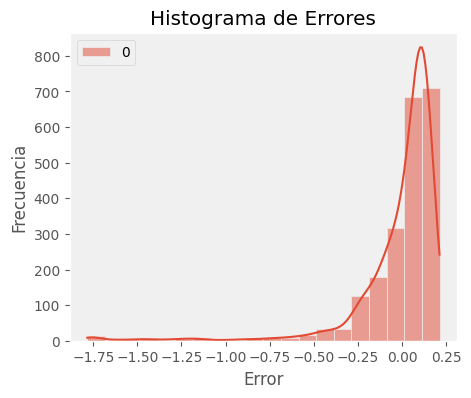

In [ ]:
graficar_histograma_errores(y_test, lr.predict(X_test.reshape(-1, 1)))

Todo apunta a que tampoco se cumple la hipótesis nula de homocedasticidad.

Por último, planteamos el test de _Breusch-Pagan_ con el que veremos efectivamente si se rechaza o no H0.

In [ ]:
import statsmodels.formula.api as sm

# Ajusta el modelo de regresión
modelo = sm.ols('importe_adj ~ importe_estimado', data=df_model_log).fit()

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Realiza el test de Breusch-Pagan
bp_test = het_breuschpagan(modelo.resid, modelo.model.exog)

# Imprime los resultados
print('Estadístico LM:', bp_test[0])
print('Valor p:', bp_test[1])
print('Estadístico F:', bp_test[2])
print('Valor p del estadístico F:', bp_test[3])

Estadístico LM: 49.031481025656326
Valor p: 2.518871766197765e-12
Estadístico F: 49.24573633686109
Valor p del estadístico F: 2.3934905298584034e-12


Como podemos observar, el p-valor es muy bajo, por lo que existen evidencias suficientes para rechaza la hipótesis nula homocedasticidad.

### **4.2.4 Interpretación de los resultados**

Como podemos observar, con un simple modelo de Regresión Lineal somos capaces de explicar el **96% de la varianza (R2)** de nuestras observaciones. Unos resultados excelentes considerando la simplicidad del modelo.

Se trata de unos resultados que tampoco nos sorprenden en exceso; ya veníamos comentando la fuerte correlación lineal positiva entre ambas variables. Así mismo, se trata de una variable fuertemente influenciada por la otra por su propia naturaleza, pues no deja de ser un importe igual o menor al estimado inicialmente.

Sin embargo, nuestro modelo está lejos de ser perfecto. Algunos de los resultados a destacar son los siguientes:
* **Promedio del Error Absoluto (MAE)**: El resultado es de 37.163 euros.
* **Promedio del Porcentaje de Error Absoluto (MAPE)**: En torno al 18%.
* **Mediana del Error Absoluto (MdAE)**: Es de 6.077 euros. Su porcentaje de desviación es del 11% **(MdAPE)**.
* **Error Cuadrático Medio (RMSE)**: 149.060 euros.

Por último, nuestro modelo no cumple dos de los tres supuestos que debe cumplir cualquier modelo lineal: la hipótesis de normalidad y la hipótesis de homocedasticidad.

Esto implica que:

* Los estimadores mínimo-cuadráticos no son eficientes (de mínima varianza).

* Los intervalos de confianza de los parámetros del modelo y los contrastes de significancia son solamente aproximados y no exactos

### **4.2.5 Resultados**

Volvemos a cargar los datos únicamente con las variables que vamos a utilizar.

In [ ]:
columnas = ['importe_adj','importe_estimado']
datos_linear = pd.read_excel('/content/drive/MyDrive/TFM/Datos/df_preprocesado.xlsx',
                   dtype= {
                       'adjudicador':'category',
                       'tipo_contrato':'category',
                       'criterio_adjudicacion':'category',
                       'procedimiento': 'category',
                       'tramitacion':'category',
                       'cod_cpv':'category',
                       'subcod_cpv_fe':'category',
                       'tipo_entidad_fe':'category'
                   })
data_lr = datos_linear[columnas]

Dividimos los datos en las variables de entrada y salida, esta vez utilizando todo el dataset.

In [ ]:
X_lr_final = data_lr.drop(columns=['importe_adj'])
y_lr_final = data_lr['importe_adj']

Entrenamos los datos con el pipeline final.

In [ ]:
lr.fit(X_lr_final, y_lr_final)

LinearRegression()

## Grabamos el modelo

In [ ]:
# Grabamos el modelo en un archivo
dump(lr, 'linear_regression.joblib')

['linear_regression.joblib']

## Usamos el modelo

In [ ]:
modelo = load('linear_regression.joblib')
modelo

LinearRegression()

In [ ]:
predicciones_finales = modelo.predict(X_lr_final)
prediccines_df = pd.DataFrame(predicciones_finales)
prediccines_df.columns = ['predicciones']

In [ ]:
df_comparativo = pd.concat([y_lr_final, prediccines_df], axis=1)
df_comparativo['dif'] = np.abs(df_comparativo['importe_adj'] - df_comparativo['predicciones'])
df_comparativo['dif_porc'] = np.abs(df_comparativo['dif'] / df_comparativo['importe_adj']*100)
df_comparativo.describe()

,importe_adj,predicciones,dif,dif_porc
count,"10,812.00","10,812.00","10,812.00","10,812.00"
mean,"251,835.80","251,835.80","32,856.44",19.14
std,"725,905.47","712,729.65","133,699.53",44.41
min,180.00,-471.04,1.49,0.01
25%,"26,049.48","25,605.97","2,585.95",7.38
50%,"59,900.00","59,819.43","6,281.25",12.52
75%,"158,268.84","159,629.67","17,632.20",15.12
max,"9,255,813.32","8,452,821.75","5,678,109.74",510.21


In [ ]:
evaluar_modelo(lr, X_lr_final, y_lr_final)

{'MAE': 32856.44,
 'MAPE': 19.14,
 'MdAE': 6281.25,
 'MdAPE': 12.52,
 'RMSE': 137671.55,
 'R²': 0.96}

## 4.3 Elección de modelos potenciales

Vamos a crear una pipeline donde las diversas transformaciones y preprocesados de los datos queden registrados y puedan ser fácilmente manipulables.

Asimismo, ayudará a la creación de un flujo de trabajo con el que realizar transformaciones de forma más eficiente y probar diversas combinaciones.

### Dividimos nuestro dataset

In [ ]:
X = df_model.drop(df_model.columns[5], axis=1)
y = df_model.iloc[:, 5]
X_train, X_test, y_train, y_test  = train_test_split(X,
                                                     y,
                                                     test_size=0.2,
                                                     random_state=42)

### **Pipeline**

Elaboramos una pipeline para el preprocesado de los datos.

Como cuestiones relevantes destacamos que:

* Vamos a utilizar el método MICE para completar los datos ausentes.
* Utilizaremos StandarScaler() para el escalado de los datos.
* Sobre las variables categóricas con varios niveles vamos a realizar uan transformación alternativa mediante la clase **CodificadorFrecuencias**. De esta forma, a cada nivel le daremos un valor en base a su frecuencia y estos valores serán posteriormente estandarizados. De esa forma controlaremos la dimensionalidad de nuestro modelo.

* **Definición de variables**

In [ ]:
# Separamos en grupos
cod_features = ['adjudicador', 'tipo_entidad_fe', 'procedimiento','cod_cpv','subcod_cpv_fe']
onehot_features = ['tipo_contrato','criterio_adjudicacion','tramitacion']
numerical_features = X.select_dtypes(include = 'number').columns

* **Creamos la clase para las frecuencias**

In [ ]:
# Creación de la clase
class CodificadorFrecuencias(BaseEstimator, TransformerMixin):
    def __init__(self, columnas):
        self.columnas = columnas

    def fit(self, X, y=None):
        return self

    def transform (self, X, y=None):
      X_transformed = X.copy()
      for columna in self.columnas:
        frecuencia = X_transformed[columna].value_counts()
        nueva_columna = columna + '_fe'
        X_transformed[nueva_columna] = X_transformed[columna].map(frecuencia)
        X_transformed.drop(columns=[columna], inplace=True)
      return X_transformed

    def get_feature_names_out(self, input_features=None):
        # Return the names of the transformed features
        return [col + '_fe' for col in self.columnas]

* **Pipe numérica**

In [ ]:
# Pipe num
num_pipeline = Pipeline(steps=[
    ('imputer', IterativeImputer(initial_strategy='most_frequent',
                                 min_value = 1,
                                 random_state = 42)),
    ('scaler', StandardScaler()),
])


* **Pipe frec**

In [ ]:
# Pipe frec
frec_pipeline = Pipeline(steps=[
    ('codificador_frecuencias', CodificadorFrecuencias(cod_features)),
    ('imputer', IterativeImputer(initial_strategy='most_frequent',
                                 min_value = 1,
                                 random_state = 42)),
    ('scaler', StandardScaler())
  ])

* **Pipe onehot**

In [ ]:
# Pipe onehot
onehot_pipeline = Pipeline([
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
  ])

* **Column Transformer**

In [ ]:
# Include all features in the ColumnTransformer
preprocesado = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, numerical_features),
    ('frec_pipeline', frec_pipeline, cod_features),
    ('onehot_pipeline', onehot_pipeline, onehot_features),
],
                                 remainder = 'drop', # Drop any remaining features not specified
                                 n_jobs = -1)

* **Resultado**

In [ ]:
preprocesado

ColumnTransformer(n_jobs=-1,
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer(initial_strategy='most_frequent',
                                                                   min_value=1,
                                                                   random_state=42)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['importe_estimado', 'no_ofertas', 'no_de_lotes_fe',
       'no_de_adjudicatarios_fe', 'duracion_fe', 'año_fe', 'mes_fe', 'dia_fe'],
      dtype='object')),
                                ('frec_pipelin...
                                                 ('imputer',
                                                  IterativeImputer(initial_strategy='most_frequent',
                                                                   min_value=1,
                                                                   random_state=42)),
                                                 ('scaler', StandardScaler())]),
                                 ['adjudicador', 'tipo_entidad_fe',
                                  'procedimiento', 'cod_cpv',
                                  'subcod_cpv_fe']),
                                ('onehot_pipeline',
                                 Pipeline(steps=[('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['tipo_contrato', 'criterio_adjudicacion',
                                  'tramitacion'])])

### **Elección de modelos**

In [ ]:
# Diccionario vacío para resultados
result_dict = {}

In [ ]:
# Extracción de características
features = list(X_train.columns)

#### **Funciones de ayuda**

In [ ]:
def entrenar_modelo(modelo,
                    preprocesado: ColumnTransformer,
                    x_data: pd.DataFrame,
                    y_data: pd.Series,
                    test_frac: float=0.2,
                    ):
  """ entrenar_modelo

  Función para entrenar y evaluar un modelo de regresión.

  Args:
    modelo: El modelo de regresión a entrenar.
    preprocesado (ColumnTransformer): pipe con el preprocesado que hemos elaborado
    x_data (DF): datos de entrada
    y_data (Series): variable objetivo
    test_frac (float): fracción de datos para el conjunto de prueba

  Returns:
    dict: diccionario con los resultados del modelo de entrenamiento y prueba
  """
  # Dividimos los datos en entrenamiento y prueba
  X_train, X_test, y_train, y_test  = train_test_split(x_data,
                                                       y_data,
                                                       test_size=test_frac,
                                                       random_state=42)
  # Creamos el pipeline con el preprocesado y el modelo
  regression_pipeline = Pipeline(steps=[
    ('preprocesado', preprocesado),
    ('modelo', modelo)
  ])
  # Entrenamos el pipeline de regresión
  model = regression_pipeline.fit(X_train, y_train)

  # Predicciones del modelo
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  # Calculamos las métricas de evaluación
  mae_train = mean_absolute_error(y_train, y_pred_train)
  mdae_train = median_absolute_error(y_train, y_pred_train)
  rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

  # Métricas test
  mae_test = mean_absolute_error(y_test, y_pred_test)
  mdae_test = median_absolute_error(y_test, y_pred_test)
  rmse_test  = mean_squared_error(y_test, y_pred_test, squared=False)

  # Visualización entrenamiento
  print(f'MAE en entrenamiento: {mae_train:.2f} euros')
  print(f'MdAE en entrenamiento: {mdae_train:.2f} euros')
  print(f'RMSE en entrenamiento: {rmse_train:.2f} euros')

  # Visualización test
  print(f'MAE en test: {mae_test:.2f} euros')
  print(f'MdAE en test: {mdae_test:.2f} euros')
  print(f'RMSE en test: {rmse_test:.2f} euros')

  return {
    'mae_train': mae_train,
    'mdae_train': mdae_train,
    'rmse_train': rmse_train,
    'mae_test': mae_test,
    'mdae_test': mdae_test,
    'rmse_test': rmse_test,
  }

In [ ]:
# Función para comparar los resultados de los modelos
# Almacenamos en un diccionario
def comparar_modelos():
  for key, value in result_dict.items():
    print('Regresión: ', key)
    print('MAE en entrenamiento: ', round(value['mae_train'],2))
    print('MdAE en entrenamiento: ', round(value['mdae_train'],2))
    print('RMSE en entrenamiento: ', round(value['rmse_train'],2))
    print('MAE en test: ', round(value['mae_test'],2))
    print('MdAE en test: ', round(value['mdae_test'],2))
    print('RMSE en test: ', round(value['rmse_test'],2))
    print()

#### **Modelo simple**

In [ ]:
result_dict['Dummy Regressor'] = entrenar_modelo(DummyRegressor(strategy='median'),
                                                 preprocesado,
                                                 X_train,
                                                 y_train)

MAE en entrenamiento: 223296.88 euros
MdAE en entrenamiento: 43571.07 euros
RMSE en entrenamiento: 733584.45 euros
MAE en test: 242255.30 euros
MdAE en test: 44292.17 euros
RMSE en test: 850259.14 euros


#### **Regresión lineal**

In [ ]:
result_dict['Linear Regression'] = entrenar_modelo(LinearRegression(),
                                                   preprocesado,
                                                   X_train,
                                                   y_train)


MAE en entrenamiento: 34211.21 euros
MdAE en entrenamiento: 11410.34 euros
RMSE en entrenamiento: 127360.16 euros
MAE en test: 40291.03 euros
MdAE en test: 11559.58 euros
RMSE en test: 141585.84 euros


#### **Ridge**

El modelo Ridge es una versión regularizada de la regresión lineal.

Este modelo resuelve los modelos de regresión utilizando como función de pérdida la función de mínimos cuadrados lineales y la regularización por el l2-normalizado.

El parámetro clave es el *alpha*, al ser la constante que controla el nivel de regularización. Cuando este es 0 es equivalente a una regresión lineal.

In [ ]:
result_dict['Ridge'] = entrenar_modelo(Ridge(alpha = 0.5),
                                       preprocesado,
                                       X_train,
                                       y_train)

MAE en entrenamiento: 34210.04 euros
MdAE en entrenamiento: 11412.79 euros
RMSE en entrenamiento: 127360.18 euros
MAE en test: 40289.05 euros
MdAE en test: 11553.30 euros
RMSE en test: 141588.95 euros


#### **Lasso**

El modelo Lasso es una versión regularizada de la Regresión Lineal: adhiere un término regularizador a la función de coste. En este caso, el término L1.

La ventaja de utilizar LASSO es que va a forzar a que algunos parámetros sean cero, con lo cual también se realiza una selección de las variables más influyentes.

Ridge regression, por su parte, incluye todas las variables predictoras en el modelo final, si bien es cierto que algunas con parámetros muy próximos a cero: de este modo va a reducir el riesgo del sobreajuste, pero no resuelve el problema de la interpretabilidad.

Otra posible ventaja de utilizar LASSO es que cuando hay variables predictoras correlacionadas tiene tendencia a seleccionar una y anular las demás (esto también se puede ver como un inconveniente, ya que pequeños cambios en los datos pueden dar lugar a distintos modelos), mientras que ridge tiende a darles igual peso.

In [ ]:
result_dict['Lasso'] = entrenar_modelo(Lasso(alpha = 0.5),
                                       preprocesado,
                                       X_train,
                                       y_train)

MAE en entrenamiento: 34210.00 euros
MdAE en entrenamiento: 11408.92 euros
RMSE en entrenamiento: 127360.16 euros
MAE en test: 40289.51 euros
MdAE en test: 11558.53 euros
RMSE en test: 141585.47 euros


#### **Elastic Net**

Este modelo es una combinación de los dos anteriores, ya que utiliza los regularizadores L1 y L2.

El hiperparámetro _alpha_ marca el peso de la regularización, donde alpha = 0 es equivalent a un modelo de Regresión Lineal (en cuyo caso es mejor utiliza este directamente).

El hiperparámetro *l1_ratio* marca el nivel de regularización de L1 y de L2. Cuando *l1_ratio* = 0.5 es el punto medio entre ambos y si *l1_ratio*= 1 es equivalente a Lasso.

In [ ]:
result_dict['ElasticNet'] = entrenar_modelo(ElasticNet(alpha = 0.5,
                                                       l1_ratio = 0.9,
                                                       max_iter = 10000),
                                            preprocesado,
                                            X_train,
                                            y_train)

MAE en entrenamiento: 37086.53 euros
MdAE en entrenamiento: 11904.07 euros
RMSE en entrenamiento: 131973.06 euros
MAE en test: 41571.64 euros
MdAE en test: 10370.36 euros
RMSE en test: 149021.96 euros


#### **SVR**

In [ ]:
result_dict['SVR'] = entrenar_modelo(SVR(kernel = 'linear',
                                          C = 0.3,
                                          epsilon = 0.05),
                                      preprocesado,
                                      X_train,
                                      y_train)

MAE en entrenamiento: 222526.29 euros
MdAE en entrenamiento: 43270.47 euros
RMSE en entrenamiento: 732515.13 euros
MAE en test: 241764.21 euros
MdAE en test: 43499.49 euros
RMSE en test: 849502.58 euros


#### **KNR**

In [ ]:
result_dict['KNR'] = entrenar_modelo(KNeighborsRegressor(n_neighbors = 10),
                                      preprocesado,
                                      X_train,
                                      y_train)

MAE en entrenamiento: 99009.80 euros
MdAE en entrenamiento: 39311.67 euros
RMSE en entrenamiento: 216776.39 euros
MAE en test: 132850.55 euros
MdAE en test: 39732.18 euros
RMSE en test: 333016.75 euros


#### **Decission Tree**

In [ ]:
result_dict['Decision Tree'] = entrenar_modelo(DecisionTreeRegressor(random_state=42),
                                               preprocesado,
                                               X_train,
                                               y_train)

MAE en entrenamiento: 2.65 euros
MdAE en entrenamiento: 0.00 euros
RMSE en entrenamiento: 116.96 euros
MAE en test: 57279.16 euros
MdAE en test: 5133.90 euros
RMSE en test: 274149.00 euros


#### **Random Forest Regressor**

In [ ]:
result_dict['Random Forest Regressor'] = entrenar_modelo(RandomForestRegressor(random_state=42),
                                                          preprocesado,
                                                          X_train,
                                                          y_train)

MAE en entrenamiento: 11012.37 euros
MdAE en entrenamiento: 1600.18 euros
RMSE en entrenamiento: 52327.82 euros
MAE en test: 38556.87 euros
MdAE en test: 4578.26 euros
RMSE en test: 162129.55 euros


#### **HistGradientBoostingRegressor**

In [ ]:
result_dict['HistBoostRegressor'] = entrenar_modelo(HistGradientBoostingRegressor(random_state=42),
                                                     preprocesado,
                                                     X_train,
                                                     y_train)

MAE en entrenamiento: 19160.02 euros
MdAE en entrenamiento: 4770.84 euros
RMSE en entrenamiento: 92912.24 euros
MAE en test: 35660.00 euros
MdAE en test: 4888.17 euros
RMSE en test: 149595.41 euros


#### **GradBoostRegressor**

In [ ]:
result_dict['GradBoostRegressor'] = entrenar_modelo(GradientBoostingRegressor(random_state=42),
                                                     preprocesado,
                                                     X_train,
                                                     y_train)

MAE en entrenamiento: 23016.03 euros
MdAE en entrenamiento: 6557.47 euros
RMSE en entrenamiento: 62907.36 euros
MAE en test: 38849.18 euros
MdAE en test: 6508.70 euros
RMSE en test: 171955.54 euros


#### **SDRegressor**

In [ ]:
result_dict['SDRegressor'] = entrenar_modelo(SGDRegressor(random_state=42),
                                                     preprocesado,
                                                     X_train,
                                                     y_train)

MAE en entrenamiento: 40281.40 euros
MdAE en entrenamiento: 15992.85 euros
RMSE en entrenamiento: 130430.04 euros
MAE en test: 44756.77 euros
MdAE en test: 14900.84 euros
RMSE en test: 144555.54 euros


#### **XGBRegressor**

In [ ]:
result_dict['XGBRegressor'] = entrenar_modelo(XGBRegressor(random_state=42),
                                                     preprocesado,
                                                     X_train,
                                                     y_train)

MAE en entrenamiento: 5934.52 euros
MdAE en entrenamiento: 3244.48 euros
RMSE en entrenamiento: 9863.81 euros
MAE en test: 49481.63 euros
MdAE en test: 6309.42 euros
RMSE en test: 229342.73 euros


#### **LGBRegressor**

In [ ]:
result_dict['LGBRegressor'] = entrenar_modelo(LGBMRegressor(random_state=42,
                                                            verbose = 0),
                                                     preprocesado,
                                                     X_train,
                                                     y_train)

MAE en entrenamiento: 19323.97 euros
MdAE en entrenamiento: 4665.66 euros
RMSE en entrenamiento: 98851.08 euros
MAE en test: 37745.71 euros
MdAE en test: 5080.34 euros
RMSE en test: 156369.59 euros


#### **CatBoostRegr**

In [ ]:
result_dict['CatBoostRegr'] = entrenar_modelo(CatBoostRegressor(random_state=42,
                                                                verbose = False),
                                                     preprocesado,
                                                     X_train,
                                                     y_train)

MAE en entrenamiento: 12036.91 euros
MdAE en entrenamiento: 5032.91 euros
RMSE en entrenamiento: 23534.45 euros
MAE en test: 48184.65 euros
MdAE en test: 5903.44 euros
RMSE en test: 252419.87 euros


### **Comparamos los resultados**

In [ ]:
comparar_modelos()

Regresión:  Dummy Regressor
MAE en entrenamiento:  223296.88
MdAE en entrenamiento:  43571.07
RMSE en entrenamiento:  733584.45
MAE en test:  242255.3
MdAE en test:  44292.17
RMSE en test:  850259.14

Regresión:  Linear Regression
MAE en entrenamiento:  34211.21
MdAE en entrenamiento:  11410.34
RMSE en entrenamiento:  127360.16
MAE en test:  40291.03
MdAE en test:  11559.58
RMSE en test:  141585.84

Regresión:  Ridge
MAE en entrenamiento:  34210.04
MdAE en entrenamiento:  11412.79
RMSE en entrenamiento:  127360.18
MAE en test:  40289.05
MdAE en test:  11553.3
RMSE en test:  141588.95

Regresión:  Lasso
MAE en entrenamiento:  34210.0
MdAE en entrenamiento:  11408.92
RMSE en entrenamiento:  127360.16
MAE en test:  40289.51
MdAE en test:  11558.53
RMSE en test:  141585.47

Regresión:  ElasticNet
MAE en entrenamiento:  37086.53
MdAE en entrenamiento:  11904.07
RMSE en entrenamiento:  131973.06
MAE en test:  41571.64
MdAE en test:  10370.36
RMSE en test:  149021.96

Regresión:  SVR
MAE en e

Vamos a introducir nuestros resultados en diccionarios y transformarlo en un DF con el que poder comparar los resultados.

In [ ]:
# Creamos un diccionario con los resultados de cada prueba del modelo
nombre_modelos = result_dict.keys()
resultados_train_mae = {}
resultados_test_mae = {}
resultados_train_mdae = {}
resultados_test_mdae = {}
#resultados_train_rmse = {}
#resultados_test_rmse = {}
for nombre in nombre_modelos:
  resultados_train_mae[nombre] = result_dict[nombre]['mae_train']
  resultados_test_mae[nombre] = result_dict[nombre]['mae_test']
  resultados_train_mdae[nombre] = result_dict[nombre]['mdae_train']
  resultados_test_mdae[nombre] = result_dict[nombre]['mdae_test']
  #resultados_train_rmse[nombre] = result_dict[nombre]['rmse_train']
  #resultados_test_rmse[nombre] = result_dict[nombre]['rmse_test']

df_comparacion = pd.DataFrame([resultados_train_mae, resultados_test_mae,
                               resultados_train_mdae, resultados_test_mdae],
                               #resultados_train_rmse, resultados_test_rmse,
                              index = ['train_mae','test_mae',
                                       'train_mdae','test_mdae'])
                                       #'train_rmse','test_rmse'])

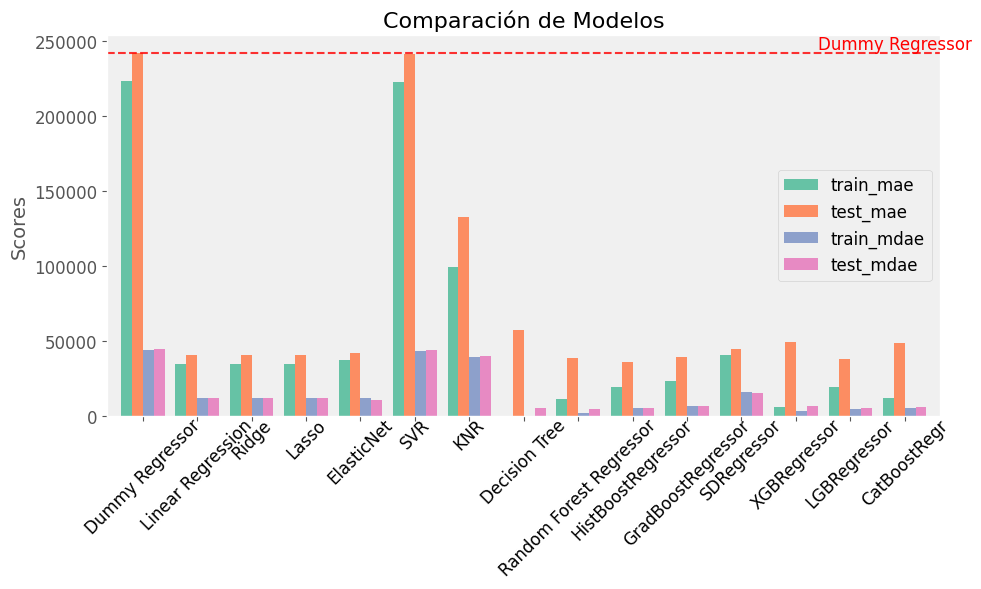

In [ ]:
# Ajustamos la paleta de colores
colors = sns.color_palette("Set2")

# Dibujamos el gráfico
fig, ax = plt.subplots(figsize=(10, 6))
df_comparacion.T.plot(kind='bar', ax=ax, width=0.8, color=colors)

# Ajustamos
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Comparación de Modelos', fontsize=16)

# Ajuste de etiquetas en el eje x
ax.set_xticks(range(len(df_comparacion.columns)))
ax.set_xticklabels([])

# Etiquetas sobre las barras, colocadas debajo y rotadas
for i, label in enumerate(df_comparacion.columns):
    ax.text(i, -0.1, label, ha='center', va='top', rotation=45, fontsize=12)

# Dibujamos la línea de referencia de 'DummyRegressor'
dummy_mae = df_comparacion.loc['test_mae', 'Dummy Regressor']
ax.axhline(dummy_mae, color='red', linestyle='--', alpha=0.8)
ax.text(len(df_comparacion.columns)-2.6, dummy_mae, 'Dummy Regressor', color='red', fontsize=12, ha='left', va='bottom')

# Añadimos una leyenda clara
ax.legend(loc='best', fontsize=12)

# Ajustamos el tamaño de la fuente de los ejes
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Ajuste final
plt.tight_layout()
plt.savefig('Compara_modelos.pdf')
plt.show()


En vista de los resultados obtenidos vamos a seleccionar los siguientes modelos con los que elegir los hiperparámetros más adecuados:
1. Ridge.
2. Random Forest Regressor.
3. HistBoostRegressor.
4. Elastic Net.
5. LGBRegressor.

Hemos seleccionado el modelo Elastic Net ya que su versatilidad en el ajuste puede dar mejores resultados que cada uno de los modelos lineales por separado.

### **Cross-Validation - Comparación de Modelos**

Vamos a analizar las varianzas de los resultados para obtener el mejor de ellos.

In [ ]:
# Creamos la lista para almacenar cada uno de los modelos seleccinados para el cross-validation
models = []

models.append(('Ridge', Ridge()))
models.append(('RFRegressor', RandomForestRegressor()))
models.append(('HGBRegressor', HistGradientBoostingRegressor()))
models.append(('ElasticNet', ElasticNet(alpha = 0.5,
                                          l1_ratio = 0.9,
                                          max_iter = 10000)))
models.append(('LGBMRegressor', LGBMRegressor(verbose = 0)))

In [ ]:
# Grabar los resultados de cada modelo
from sklearn import model_selection

# Ponemos la semilla para la reproducibilidad de los resultados
seed = 4
results = []
names = []
scoring = 'neg_mean_absolute_error'

for name, model in models:
  # Kfold cross-validation para la selección
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    model_pipe = Pipeline(steps=[
        ('preprocesado',preprocesado),
        ('modelo', model)
    ])

    # Entrenamos
    cv_results = model_selection.cross_val_score(model_pipe,
                                                 X_train,
                                                 y_train,
                                                   cv = kfold,
                                                 scoring = scoring)

    # Por si queremos utilizar la métrica de 'neg_mean_absolute_error' a abs
    cv_results = np.abs(cv_results)

    results.append(cv_results)
    names.append(name)

    resultados = f'{name}, {cv_results.mean():.2f}, {cv_results.std():.2f}'
    print(resultados)

Ridge, 36007.08, 3329.86
RFRegressor, 34961.98, 4121.05
HGBRegressor, 34030.50, 3813.23
ElasticNet, 37215.64, 3499.82
LGBMRegressor, 33926.40, 3925.54


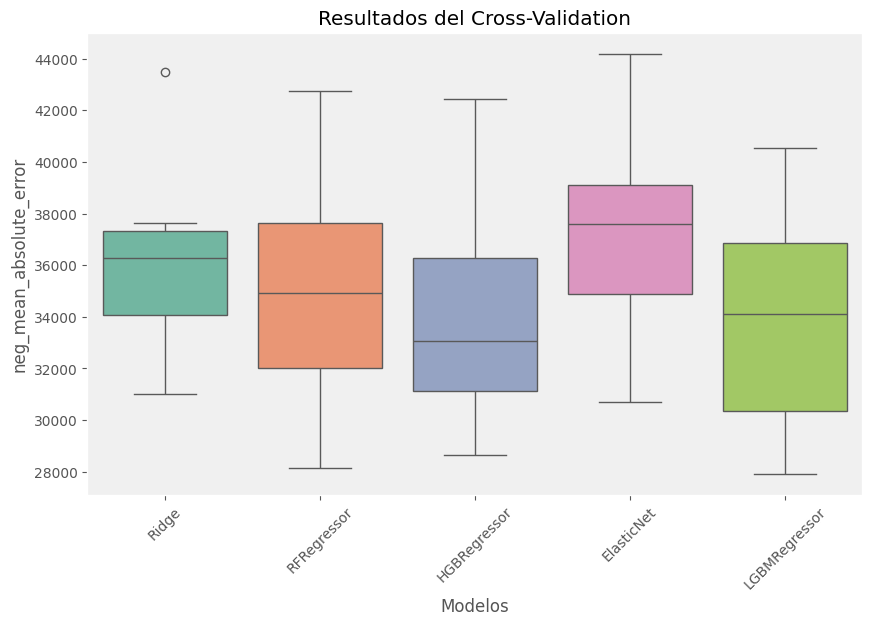

In [ ]:
plt.figure(figsize=(10, 6))
results_df = pd.DataFrame(results, index=names)
sns.boxplot(data=results_df.transpose(),
            palette = 'Set2')
plt.title('Resultados del Cross-Validation')
plt.xlabel('Modelos')
plt.ylabel('neg_mean_absolute_error')
plt.xticks(rotation=45)
plt.savefig('Boxplot_modelos.pdf')
plt.show()

El boxplot nos aporta información muy valiosa sobre estos modelos:
* Todos los resultados obtenidos varían en una horquilla entre los 30.000 y 47.000 euros de desviación media.
* Hay dos modelos cuya varianza es relativamente pequeña en comparación con los demás: el modelo LGBMRegressor y el HistGradientBoostingRegressor, con horquillas de unos 10.000 euros aproximadamente. El resto varían en un rango de unos 10.000-15.000 euros.
* Cabe destacar que los dos modelos que tienen una menor varianza son también los únicos que tienen outliers.

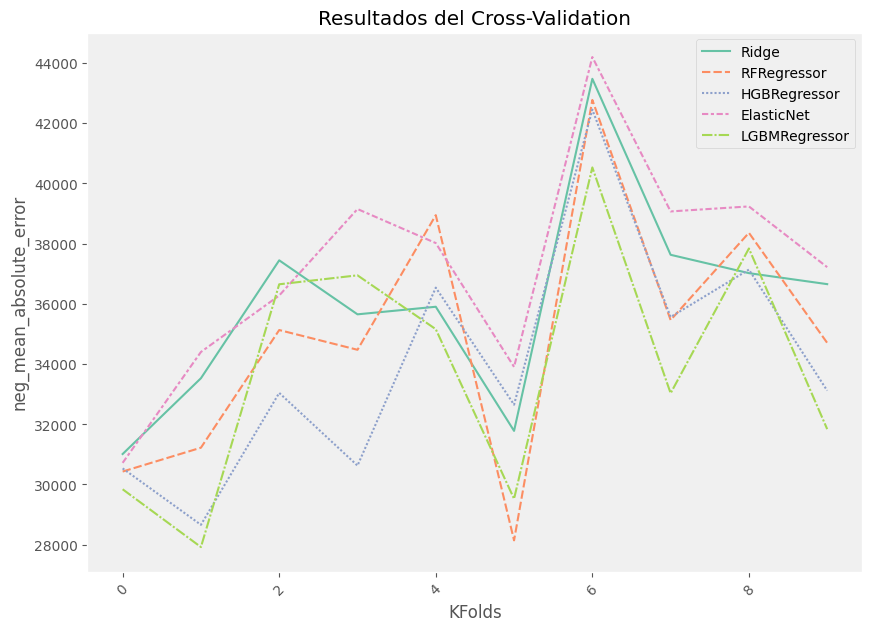

In [ ]:
plt.figure(figsize=(10,7))
sns.lineplot(data=results_df.transpose(),
             palette = 'Set2')
plt.title('Resultados del Cross-Validation')
plt.xlabel('KFolds')
plt.ylabel('neg_mean_absolute_error')
plt.xticks(rotation=45)
plt.show()


Como puede observarse, todos los modelos tienen un comportamiento muy variable hasta el 5 KFold. A partir de esto, todos los modelos siguen una tendencia similar y obtienen MAE's muy similares en el último ciclo.

Parece que la elección de un modelo u otro no afectará mucho a nuestro resultados.

Sin embargo, lo confirmaremos con la siguiente prueba.

### **Comparación estadística de los modelos**

In [ ]:
# Utilizamos el test-F para determinar si los distintos modelos presentas resultados
# significativamente distintos
# ==============================================================================
from scipy.stats import f_oneway

model1 = results_df.transpose()['Ridge']
model2 = results_df.transpose()['RFRegressor']
model3 = results_df.transpose()['HGBRegressor']
model4 = results_df.transpose()['ElasticNet']
model5 = results_df.transpose()['LGBMRegressor']

# Realizamos la prueba F
statistics, p_value = f_oneway(model1, model2, model3, model4, model5)

print("Estadística F:", statistics)
print("Valor p:", p_value)

if p_value < 0.05:
    print("Existe una diferencia estadísticamente "
    "significativa en los resultados de "
    "cross-validation de los modelos ")
else:
    print("No existe una diferencia estadísticamente "
    "significativa en los resultados de "
    "cross-validation de los modelos ")

Estadística F: 1.2418025357280282
Valor p: 0.30688152622093406
No existe una diferencia estadísticamente significativa en los resultados de cross-validation de los modelos 


### **Hyper Parameter Tunning**

Los hiperparámetros son los parámetros de un estimador que no se van aprendiendo según se entrena un modelo, sino que vienen predefinidos antes de proceder al entrenamiento.

Mediante una selección ajustada de los hiperparámetros vamos a ser capaces de obtener unos mejores resultados

Para ello utilizaremos las dos técnicas existentes: GridSearchCV para una búsqueda exhaustiva y RandomSearchCV para una búsqueda aleatoria. La elección entre ambas consistirá en el coste computacional que requiera cada una de ellas.

#### **Ridge model**

El parámetro clave es el *alpha*, al ser la constante que controla el nivel de regularización. Cuando es 0 es equivalente a una regresión lineal.

In [ ]:
parameters = {'model__alpha':[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,0.85, 0.9, 0.95, 1]}

In [ ]:
ridge_pipe = Pipeline(steps=[
    ('preprocesado', preprocesado),
    ('model', Ridge())
])

In [ ]:
# Aplicamos el GridSearch
grid_search = GridSearchCV(ridge_pipe,
                           parameters,
                           cv = 5,
                           return_train_score = True,
                           scoring = ['neg_mean_absolute_error','neg_median_absolute_error','r2'],
                           refit = 'neg_mean_absolute_error')

In [ ]:
# Entrenamos el modelo
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer(initial_strategy='most_frequent',
                                                                                                           min_value=1,
                                                                                                           random_state=42)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['importe_estimado', 'no_ofertas', 'no_de_lotes_fe',
       'no_de_adjudicatarios_fe', 'duracion_fe'...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['tipo_contrato',
                                                                          'criterio_adjudicacion',
                                                                          'tramitacion'])])),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                                          0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
                                          0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=['neg_mean_absolute_error', 'neg_median_absolute_error',
                      'r2'])

In [ ]:
# Imprimimos los resultados
print(f'Mejor resultado = {round(abs(grid_search.best_score_),2)}')
print(f'Mejor MAE promedio (validación cruzada) = {round(-grid_search.cv_results_["mean_test_neg_mean_absolute_error"][grid_search.best_index_],2)}')
print(f'Mejor MdAE promedio (validación cruzada) = {round(-grid_search.cv_results_["mean_test_neg_median_absolute_error"][grid_search.best_index_],2)}')
print(f'Mejor std (MAE) = {round(grid_search.cv_results_["std_test_neg_mean_absolute_error"][grid_search.best_index_],2)}')
print(f'Mejor std (MedAE) = {round(grid_search.cv_results_["std_test_neg_median_absolute_error"][grid_search.best_index_],2)}')
print(f'Mejor parámetro = {grid_search.best_params_}')

Mejor resultado = 35770.57
Mejor MAE promedio (validación cruzada) = 35770.57
Mejor MdAE promedio (validación cruzada) = 11801.78
Mejor std (MAE) = 2781.99
Mejor std (MedAE) = 496.08
Mejor parámetro = {'model__alpha': 1}


Observamos que el MAE ha mejorado en más de 4.000 euros (un 10%), aunque los valores del MdAE han sido ligeramente peores.


Podemos observar los resultados de la cross-validation mediante la siguiente función:

In [ ]:
for i in range(len(parameters['model__alpha'])):
  print('Parámetros: ',grid_search.cv_results_['params'][i])
  print('MAE: ', round(-grid_search.cv_results_['mean_test_neg_mean_absolute_error'][i],2))
  print('MdAE: ', round(-grid_search.cv_results_['mean_test_neg_median_absolute_error'][i],2))
  print('R2: ', round(grid_search.cv_results_['mean_test_r2'][i], 2))
  print('Rank: ', round(-grid_search.cv_results_['rank_test_neg_mean_absolute_error'][i],2))

Parámetros:  {'model__alpha': 0.01}
MAE:  35775.17
MdAE:  11813.2
R2:  0.97
Rank:  -21
Parámetros:  {'model__alpha': 0.05}
MAE:  35774.98
MdAE:  11811.99
R2:  0.97
Rank:  -20
Parámetros:  {'model__alpha': 0.1}
MAE:  35774.74
MdAE:  11809.79
R2:  0.97
Rank:  -19
Parámetros:  {'model__alpha': 0.15}
MAE:  35774.51
MdAE:  11807.81
R2:  0.97
Rank:  -18
Parámetros:  {'model__alpha': 0.2}
MAE:  35774.27
MdAE:  11806.6
R2:  0.97
Rank:  -17
Parámetros:  {'model__alpha': 0.25}
MAE:  35774.04
MdAE:  11805.91
R2:  0.97
Rank:  -16
Parámetros:  {'model__alpha': 0.3}
MAE:  35773.81
MdAE:  11805.22
R2:  0.97
Rank:  -15
Parámetros:  {'model__alpha': 0.35}
MAE:  35773.57
MdAE:  11804.53
R2:  0.97
Rank:  -14
Parámetros:  {'model__alpha': 0.4}
MAE:  35773.34
MdAE:  11803.71
R2:  0.97
Rank:  -13
Parámetros:  {'model__alpha': 0.45}
MAE:  35773.1
MdAE:  11802.94
R2:  0.97
Rank:  -12
Parámetros:  {'model__alpha': 0.5}
MAE:  35772.87
MdAE:  11802.21
R2:  0.97
Rank:  -11
Parámetros:  {'model__alpha': 0.55}
MAE:

#### **Elastic Net model**

Al igual que con el modelo anterior, el parámetro *alpha* es clave dado que marca el nivel de regularización.

In [ ]:
parameters = {'model__alpha':[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                              0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,0.85, 0.9, 0.95, 1],
              'model__l1_ratio': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                              0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,0.85, 0.9, 0.95, 1],
              'model__max_iter': list(range(1,1000,200))}

In [ ]:
elastic_pipe = Pipeline(steps=[
    ('preprocesado', preprocesado),
    ('model', ElasticNet())
])

In [ ]:
random_search = RandomizedSearchCV(elastic_pipe,
                           parameters,
                           cv = 5,
                           scoring = ['neg_mean_absolute_error','neg_median_absolute_error','r2'],
                           refit = 'neg_mean_absolute_error')

In [ ]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocesado',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('imputer',
                                                                                                IterativeImputer(initial_strategy='most_frequent',
                                                                                                                 min_value=1,
                                                                                                                 random_state=42)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['importe_estimado', 'no_ofertas', 'no_de_lotes_fe',
       'no_de_adjudicatarios_fe', 'duraci...
                   param_distributions={'model__alpha': [0.01, 0.05, 0.1, 0.15,
                                                         0.2, 0.25, 0.3, 0.35,
                                                         0.4, 0.45, 0.5, 0.55,
                                                         0.6, 0.65, 0.7, 0.75,
                                                         0.8, 0.85, 0.9, 0.95,
                                                         1],
                                        'model__l1_ratio': [0.01, 0.05, 0.1,
                                                            0.15, 0.2, 0.25,
                                                            0.3, 0.35, 0.4,
                                                            0.45, 0.5, 0.55,
                                                            0.6, 0.65, 0.7,
                                                            0.75, 0.8, 0.85,
                                                            0.9, 0.95, 1],
                                        'model__max_iter': [1, 201, 401, 601,
                                                            801]},
                   refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error',
                            'neg_median_absolute_error', 'r2'])

In [ ]:
print(f'Mejor resultado = {round(abs(random_search.best_score_),2)}')
print(f'Mejor MAE promedio (validación cruzada) = {round(-random_search.cv_results_["mean_test_neg_mean_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor MdAE promedio (validación cruzada) = {round(-random_search.cv_results_["mean_test_neg_median_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor std (MAE) = {round(random_search.cv_results_["std_test_neg_mean_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor std (MedAE) = {round(random_search.cv_results_["std_test_neg_median_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor parámetro = {random_search.best_params_}')

Mejor resultado = 35664.6
Mejor MAE promedio (validación cruzada) = 35664.6
Mejor MdAE promedio (validación cruzada) = 11462.03
Mejor std (MAE) = 2725.43
Mejor std (MedAE) = 464.98
Mejor parámetro = {'model__max_iter': 601, 'model__l1_ratio': 0.95, 'model__alpha': 0.1}


#### **Modelo Random Forest Regressor**

Mientras que los modelos Ridge y Lasso son modelos lineales (con ajustes ligeramente diferente a la regresión lineal), el modelo de Random Forest Regressor (RFR) sigue unos principios distintos.

RFR es un modelo de ensamblado basado en árboles de decisión utilizando el método de bagging, en el que el conjunto de entrenamiento es dividido en diversas muestras aleatorias y posteriormente se realiza la media de todas las predicciones realizadas.

Es una técnica que tiene grandes ventajas ya que es capaz de reducir significativamente la varianza (previniendo el overfitting) sin por ello aumentar el sesgo.

In [ ]:
parameters = {'model__n_estimators': [100, 200, 400, 600, 800, 1000], #Nº de árboles
              'model__max_depth': [4, 5, 7, 9, 10, None], # Profundidad máxima que puede alcanzar el árbol
              'model__max_features': [1,3, 5, 7, 10, 15, 20, 25], # Número máximo de características a considerar en cada división
              'model__criterion': ['squared_error',
                                   'absolute_error',
                                   'poisson',
                                   'friedman_mse'],
              }

In [ ]:
rf_pipe = Pipeline(steps=[
    ('preprocesado', preprocesado),
    ('model', RandomForestRegressor())
])

In [ ]:
grid_search = RandomizedSearchCV(rf_pipe,
                           parameters,
                           cv = 5,
                           scoring = ['neg_mean_absolute_error','neg_median_absolute_error','r2'],
                           refit = 'neg_mean_absolute_error')

In [ ]:
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocesado',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('imputer',
                                                                                                IterativeImputer(initial_strategy='most_frequent',
                                                                                                                 min_value=1,
                                                                                                                 random_state=42)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['importe_estimado', 'no_ofertas', 'no_de_lotes_fe',
       'no_de_adjudicatarios_fe', 'duraci...
                                              RandomForestRegressor())]),
                   param_distributions={'model__criterion': ['squared_error',
                                                             'absolute_error',
                                                             'poisson',
                                                             'friedman_mse'],
                                        'model__max_depth': [4, 5, 7, 9, 10,
                                                             None],
                                        'model__max_features': [1, 3, 5, 7, 10,
                                                                15, 20, 25],
                                        'model__n_estimators': [100, 200, 400,
                                                                600, 800,
                                                                1000]},
                   refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error',
                            'neg_median_absolute_error', 'r2'])

In [ ]:
print(f'Mejor resultado = {round(abs(grid_search.best_score_),2)}')
print(f'Mejor MAE promedio (validación cruzada) = {round(-grid_search.cv_results_["mean_test_neg_mean_absolute_error"][grid_search.best_index_],2)}')
print(f'Mejor MdAE promedio (validación cruzada) = {round(-grid_search.cv_results_["mean_test_neg_median_absolute_error"][grid_search.best_index_],2)}')
print(f'Mejor std (MAE) = {round(grid_search.cv_results_["std_test_neg_mean_absolute_error"][grid_search.best_index_],2)}')
print(f'Mejor std (MedAE) = {round(grid_search.cv_results_["std_test_neg_median_absolute_error"][grid_search.best_index_],2)}')
print(f'Mejor parámetro = {grid_search.best_params_}')

Mejor resultado = 32925.68
Mejor MAE promedio (validación cruzada) = 32925.68
Mejor MdAE promedio (validación cruzada) = 5466.63
Mejor std (MAE) = 2667.06
Mejor std (MedAE) = 342.98
Mejor parámetro = {'model__n_estimators': 100, 'model__max_features': 15, 'model__max_depth': None, 'model__criterion': 'absolute_error'}


#### **Histogram Gradient Boosting Regressor**

Un modelo Gradient Boosting Trees está formado por un conjunto (ensemble) de árboles de decisión individuales, entrenados de forma secuencial.

Cada nuevo árbol emplea información del árbol anterior para aprender de sus errores, mejorando iteración a iteración. En cada árbol individual, las observaciones se van distribuyendo por bifurcaciones (nodos) generando la estructura del árbol hasta alcanzar un nodo terminal.

La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

La diferencia principal respecto al RFR es que en este tipo de modelos la técnica de ensamblado (_ensemble_) utilizada es el _Boosting_, en la cual se utilizan sucesivamente árboles pequeños (de pocas ramificaciones).

Es por esto que los hiperparámetros más importantes a ajustar son:
* El número de _weak learners_ o de número de iteraciones: a diferencia del RFR estos modelos pueden sufrir overfitting si este valor es excesivamente alto. Para evitarlo se utiliza un término de regularización conocido como **learning rate**.
* _Learning rate_: controla la influencia de cada _weak learner_ (árbol) en el conjunto (ensemble). Suelen recomendarse valores de entre 0.001 y 0.1. Cuanto menor es su valor, más árboles se necesitan pero también es menor el riesgo de overfitting.
* Si los weak learners son árboles, el _tamaño máximo_ permitido de cada árbol. Suelen emplearse valores pequeños, entre 1 y 10

In [ ]:
parameters = {'model__loss':['squared_error','absolute_error'],
              'model__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
              'model__max_iter': list(range(1,1000,200)),
              'model__max_leaf_nodes': list(range(1,100,20)),
              'model__max_depth': [1,3, 5, 7, 9, 10, None]
              }

In [ ]:
hgb_pipe = Pipeline(steps=[
    ('preprocesado', preprocesado),
    ('model', HistGradientBoostingRegressor())
])

In [ ]:
random_search = RandomizedSearchCV(hgb_pipe,
                           parameters,
                           cv = 10,
                           scoring = ['neg_mean_absolute_error','neg_median_absolute_error','r2'],
                           refit = 'neg_mean_absolute_error')

In [ ]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocesado',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('imputer',
                                                                                                IterativeImputer(initial_strategy='most_frequent',
                                                                                                                 min_value=1,
                                                                                                                 random_state=42)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['importe_estimado', 'no_ofertas', 'no_de_lotes_fe',
       'no_de_adjudicatarios_fe', 'durac...
                                              HistGradientBoostingRegressor())]),
                   param_distributions={'model__learning_rate': [0.01, 0.025,
                                                                 0.05, 0.075,
                                                                 0.1],
                                        'model__loss': ['squared_error',
                                                        'absolute_error'],
                                        'model__max_depth': [1, 3, 5, 7, 9, 10,
                                                             None],
                                        'model__max_iter': [1, 201, 401, 601,
                                                            801],
                                        'model__max_leaf_nodes': [1, 21, 41, 61,
                                                                  81]},
                   refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error',
                            'neg_median_absolute_error', 'r2'])

In [ ]:
print(f'Mejor resultado = {round(abs(random_search.best_score_),2)}')
print(f'Mejor MAE promedio (validación cruzada) = {round(-random_search.cv_results_["mean_test_neg_mean_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor MdAE promedio (validación cruzada) = {round(-random_search.cv_results_["mean_test_neg_median_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor std (MAE) = {round(random_search.cv_results_["std_test_neg_mean_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor std (MdAE) = {round(random_search.cv_results_["std_test_neg_median_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor parámetro = {random_search.best_params_}')

Mejor resultado = 32463.53
Mejor MAE promedio (validación cruzada) = 32463.53
Mejor MdAE promedio (validación cruzada) = 3667.89
Mejor std (MAE) = 3181.83
Mejor std (MdAE) = 249.92
Mejor parámetro = {'model__max_leaf_nodes': 21, 'model__max_iter': 801, 'model__max_depth': 5, 'model__loss': 'absolute_error', 'model__learning_rate': 0.025}


#### **Light GBRegressor**

Se trata de un modelo de ensamblado igualmente basado en _boosting_. Es muy utilizado debido a sus buenos resultados y a su velocidad de ejecución.

In [ ]:
parameters = {
    'model__n_estimators': [100, 200, 400, 600, 800, 1000],
    'model__num_leaves': [10, 20, 30, 40, 50],
    'model__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
    'model__max_depth': [1,3, 5, 7, 9, 10, None],
}

In [ ]:
lgbr_pipe = Pipeline(steps=[
    ('preprocesado', preprocesado),
    ('model', LGBMRegressor(verbose=-1))
    ])

In [ ]:
random_search = RandomizedSearchCV(lgbr_pipe,
                           parameters,
                           cv = 10,
                           scoring = ['neg_mean_absolute_error','neg_median_absolute_error','r2'],
                           refit = 'neg_mean_absolute_error')

In [ ]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocesado',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('imputer',
                                                                                                IterativeImputer(initial_strategy='most_frequent',
                                                                                                                 min_value=1,
                                                                                                                 random_state=42)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['importe_estimado', 'no_ofertas', 'no_de_lotes_fe',
       'no_de_adjudicatarios_fe', 'durac...
                                                                                'tramitacion'])])),
                                             ('model',
                                              LGBMRegressor(verbose=-1))]),
                   param_distributions={'model__learning_rate': [0.01, 0.025,
                                                                 0.05, 0.075,
                                                                 0.1],
                                        'model__max_depth': [1, 3, 5, 7, 9, 10,
                                                             None],
                                        'model__n_estimators': [100, 200, 400,
                                                                600, 800,
                                                                1000],
                                        'model__num_leaves': [10, 20, 30, 40,
                                                              50]},
                   refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error',
                            'neg_median_absolute_error', 'r2'])

In [ ]:
print(f'Mejor resultado = {round(abs(random_search.best_score_),2)}')
print(f'Mejor MAE promedio (validación cruzada) = {round(-random_search.cv_results_["mean_test_neg_mean_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor MdAE promedio (validación cruzada) = {round(-random_search.cv_results_["mean_test_neg_median_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor std (MAE) = {round(random_search.cv_results_["std_test_neg_mean_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor std (MedAE) = {round(random_search.cv_results_["std_test_neg_median_absolute_error"][random_search.best_index_],2)}')
print(f'Mejor parámetro = {random_search.best_params_}')

Mejor resultado = 34593.24
Mejor MAE promedio (validación cruzada) = 34593.24
Mejor MdAE promedio (validación cruzada) = 5951.83
Mejor std (MAE) = 3346.42
Mejor std (MedAE) = 486.34
Mejor parámetro = {'model__num_leaves': 10, 'model__n_estimators': 1000, 'model__max_depth': 9, 'model__learning_rate': 0.025}


## 4.4 HistGradientBoosting Regressor

Como mejor modelo hemos elegido el **Histogram Gradient Boosting Regressor** con los siguientes parámetros:

```
{'model__max_leaf_nodes': 61,
'model__max_iter': 801,
'model__max_depth': None,
'model__loss': 'absolute_error',
'model__learning_rate': 0.1}
```
Con estos hemos logrado minimizar el MAE y MdAE así como su desviación típica.


Veamos ahora qué podemos interpretar de este modelo.

### **Modelo**

In [ ]:
model = HistGradientBoostingRegressor(learning_rate=0.01,
                                       loss='absolute_error',
                                       max_depth=None,
                                       max_iter=601,
                                       max_leaf_nodes=61,
                                      random_state=42)

In [ ]:
hgb_pipe = Pipeline(steps=[
    ('preprocesado', preprocesado),
    ('model', model)
])

In [ ]:
hgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocesado',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(initial_strategy='most_frequent',
                                                                                    min_value=1,
                                                                                    random_state=42)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['importe_estimado', 'no_ofertas', 'no_de_lotes_fe',
       'no_de_adjudicatarios_fe', 'duracion_fe', 'año_fe', 'mes_fe', 'dia_fe']...
                                                  ['adjudicador',
                                                   'tipo_entidad_fe',
                                                   'procedimiento', 'cod_cpv',
                                                   'subcod_cpv_fe']),
                                                 ('onehot_pipeline',
                                                  Pipeline(steps=[('onehot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tipo_contrato',
                                                   'criterio_adjudicacion',
                                                   'tramitacion'])])),
                ('model',
                 HistGradientBoostingRegressor(learning_rate=0.01,
                                               loss='absolute_error',
                                               max_iter=601, max_leaf_nodes=61,
                                               random_state=42))])

In [ ]:
predicciones = hgb_pipe.predict(X_test)
predicciones = predicciones.flatten()

# Error de test en el modelo
rmse_ols = mean_squared_error(y_test,
                              predicciones,
                              squared = False
                              )
print('El error RMSE en test es:', round(rmse_ols,2))

El error RMSE en test es: 152049.44


In [ ]:
# Resultados de test
# ==============================================================================
evaluar_modelo(hgb_pipe, X_test, y_test)

{'MAE': 29209.37,
 'MAPE': 17.62,
 'MdAE': 3755.71,
 'MdAPE': 6.03,
 'RMSE': 152049.44,
 'R²': 0.95}

### Visualización de resultados

In [ ]:
# Guardamos los resultados para su visualización
# ==============================================================================
mae, mape, mdae, mdape, rmse, r2 = evaluar_modelo(hgb_pipe, X_test, y_test).values()
resultados = '\n'.join((
    r'$R^2 = %.2f$' % (r2, ),
    r'MAE = %.2f' % (mae, ),
    r'MAPE = %.2f' % (mape, ),
    r'MdAE = %.2f' % (mdae, ),
    r'MdAPE = %.2f' % (mdape, ),
    r'RMSE = %.2f' % (rmse, )
    ))
# Guardamos los residuos para su visualización
# ==============================================================================
residuals = y_test - hgb_pipe.predict(X_test)

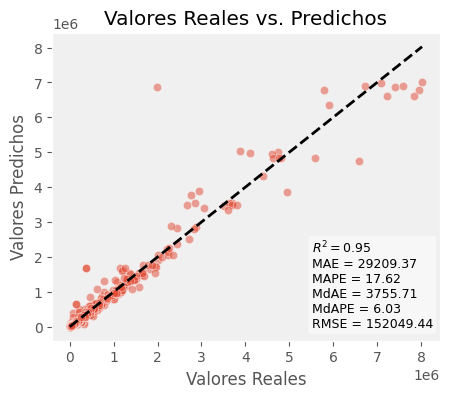

<Figure size 640x480 with 0 Axes>

In [ ]:
graficar_resultados(y_test, hgb_pipe.predict(X_test), resultados)
plt.savefig('Predicciones_hgb_test.pdf')

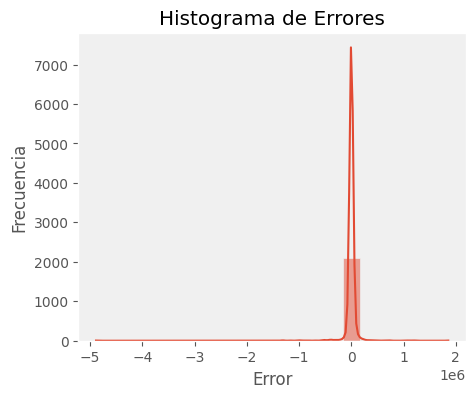

<Figure size 640x480 with 0 Axes>

In [ ]:
graficar_histograma_errores(y_test, hgb_pipe.predict(X_test))
plt.savefig('Histograma_errores_hgb_test.pdf')

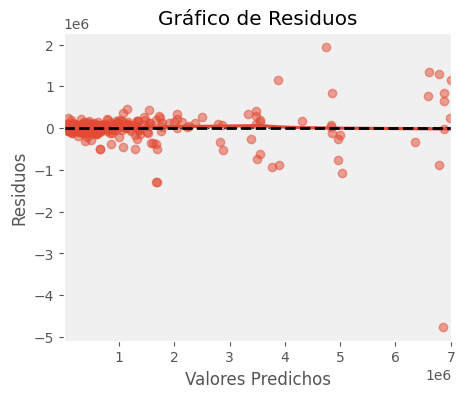

<Figure size 640x480 with 0 Axes>

In [ ]:
graficar_residuos(y_test, hgb_pipe.predict(X_test))
plt.savefig('Residuos_hgb_test.pdf')

### Curvas de aprendizaje y validación

En primer lugar, veamos cómo evoluciona la explicabilidad del modelo según aumenta el número de observaciones.

Podemos observar que a partir de las 5500 observaciones de entrenamiento tanto el conjunto de train como de test convergen en el 95% del coefieciente de determinación (R2). Con el resto de observaciones la línea se aplana y no se aprecia una mejoría tan clara.

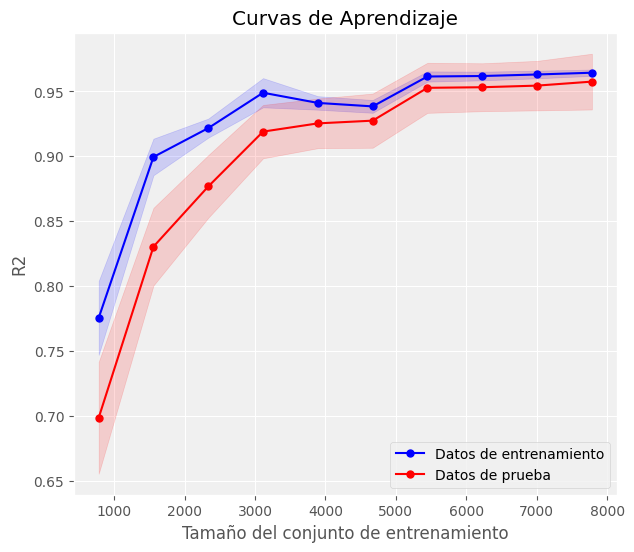

In [ ]:
curvasAprendizaje(X_train, y_train, hgb_pipe)

Con la función de la curva de validación comos capaces de observar la evolución de la métrica de scoring que utilicemos (en este caso el MAE) en relación a cómo varía el hiperparámetro que determinemos.

En este caso los hemos comparado con el número de iteraciones (número de arboles) de nuestro modelo.

Como puede observarsen el punto óptimo se alcanza en torno a los 600 árboles, precisamente el que habíamos detectado en el proceso de _fine tuning_.

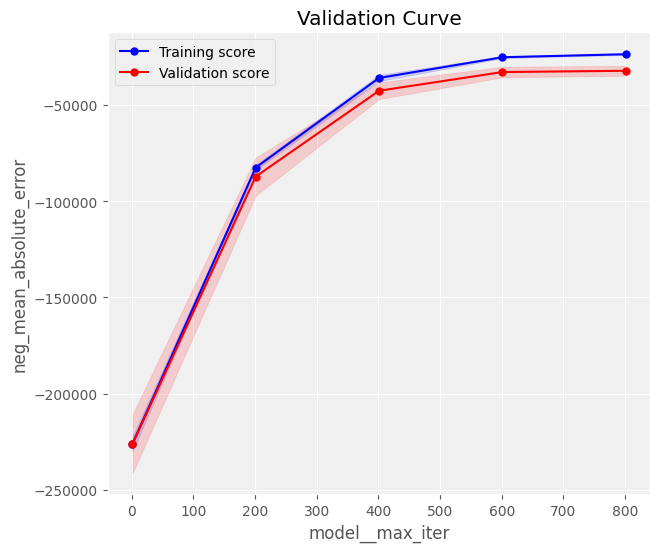

In [ ]:
param_range = np.arange(1,1000,200)
curvaValidacion(hgb_pipe, X_train, y_train, 'model__max_iter', param_range, cv = 5, scoring ='neg_mean_absolute_error')

Por último, hemos realizado el mismo análisis pero con la métrica del RMSE, donde volvemos a observar que el resultado más óptimo se encuentra con las 600 iteraciones.

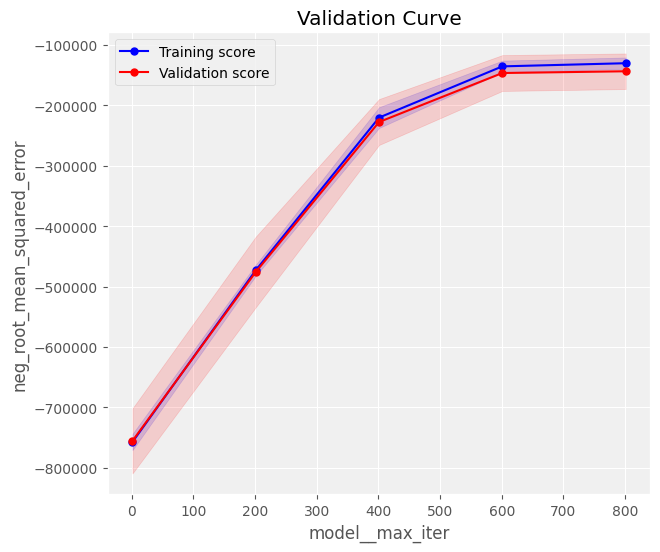

In [ ]:
param_range = np.arange(1,1000,200)
curvaValidacion(hgb_pipe, X_train, y_train, 'model__max_iter', param_range, cv = 5, scoring ='neg_root_mean_squared_error')

### Interpretación del modelo

Vamos a utilizar el módulo ```permutation_importance``` para tratar de medir qué características tiene el mayor impacto sobre nuestro modelo.

Esta técnica se basa en realizar un cambio aleatorio en los valores de una variable y a partir de ahí medir su impacto en el modelo.

Rompiendo la relación entre la característica(Xn) y la variable objetivo (y) somos capaces de medir su importancia.

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
imps = permutation_importance(estimator = hgb_pipe,
                              X = X_train,
                              y = y_train,
                              n_repeats= 5,
                              scoring= 'neg_root_mean_squared_error',
                              n_jobs=- 1,
                              random_state=42)

In [ ]:
df_importancia = pd.DataFrame(
    {k: imps[k] for k in ['importances_mean', 'importances_std']}
)
df_importancia['feature'] = X_train.columns
df_importancia.sort_values(by='importances_mean', ascending=False, inplace=True)

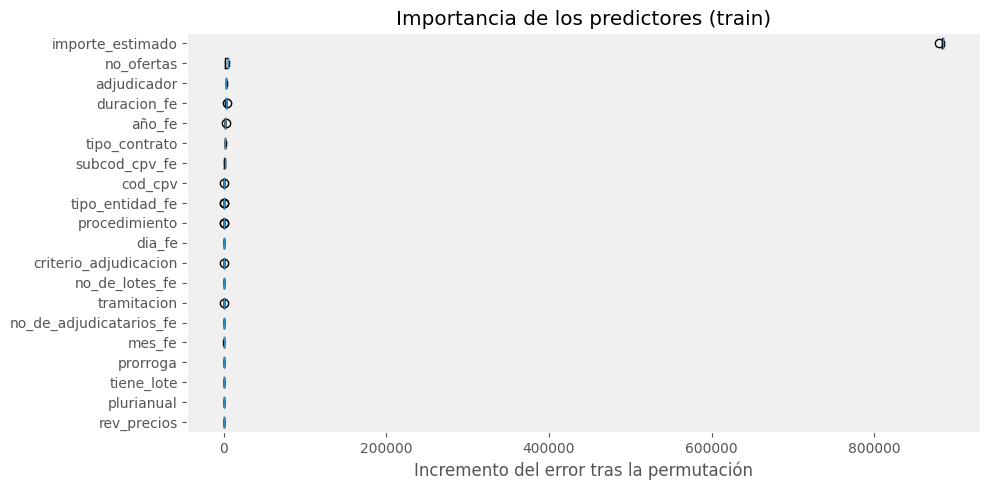

In [ ]:
# Gráfico
fig, ax = plt.subplots(figsize = (10,5))
sorted_idx = imps.importances_mean.argsort()
ax.boxplot(
    imps.importances[sorted_idx].T,
    vert = False,
    labels = X_train.columns[sorted_idx]
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')
fig.tight_layout()
plt.show()

Viendo la gráfica queda patente que todo el peso del modelo recae sobre una sola variable, que es el **importe_estimado**.

En una menor medida, tienen un ligero impacto:
* El nº de ofertas.
* La duración de los contratos.
* El ente adjudicador.

El resto de variables tienen una importancia cercana a 0.

### **Modelo simplificado**

En base a los resultados obtenidos, vamos a realizar un modelo simplificado utilizando únicamente las **4 primeras variables**.

In [ ]:
#cols_seleccionadas = ['cod_cpv','tipo_contrato','año_fe','duracion_fe','ratio','no_ofertas','subcod_cpv_fe','no_de_lotes_fe','no_de_adjudicatarios_fe']
cols_seleccionadas = ['importe_estimado','no_ofertas','adjudicador','duracion_fe']

In [ ]:
X_train = X_train[cols_seleccionadas]
X_test = X_test[cols_seleccionadas]

In [ ]:
X_train.head()

,importe_estimado,no_ofertas,adjudicador,duracion_fe
2067,"60,262.35",2.00,villatuerta,67.00
4035,"234,575.00",4.00,navarra impulsa cultura deporte ocio sl,"1,825.00"
1599,"12,000.00",2.00,ancin,"1,825.00"
9172,"362,780.00",1.00,navarra infraestructuras cultura deporte ocio sl,"1,460.00"
9834,"931,923.36",NaN,mendavia,"1,825.00"


Dado que las variables predictoras han cambiado, tenemos que modificar nuestro pipeline ligeramente.

* **Definición de variables**

In [ ]:
# Separamos en grupos
cod_features = ['adjudicador']
#onehot_features = ['tipo_contrato']
numerical_features = X_train.select_dtypes(include = 'number').columns

* **Creamos la clase para las frecuencias**

In [ ]:
# Creación de la clase
# ==============================================================================
class CodificadorFrecuencias(BaseEstimator, TransformerMixin):
    def __init__(self, columnas):
        self.columnas = columnas

    def fit(self, X, y=None):
        return self

    def transform (self, X, y=None):
      X_transformed = X.copy()
      for columna in self.columnas:
        frecuencia = X_transformed[columna].value_counts()
        nueva_columna = columna + '_fe'
        X_transformed[nueva_columna] = X_transformed[columna].map(frecuencia)
        X_transformed.drop(columns=[columna], inplace=True)
      return X_transformed

    def get_feature_names_out(self, input_features=None):
        # Devuelve los nombres de las columnas transformadas
        return [col + '_fe' for col in self.columnas]

* **Pipe numérica**

In [ ]:
# Pipe numérica
# ==============================================================================
num_pipeline = Pipeline(steps=[
    ('imputer', IterativeImputer(initial_strategy='most_frequent',
                                 min_value = 1,
                                 random_state = 42)),
    ('scaler', StandardScaler()),
])


* **Pipe frec**

In [ ]:
# Pipe frecuencia
# =============================================================================
frec_pipeline = Pipeline(steps=[
    ('codificador_frecuencias', CodificadorFrecuencias(cod_features)),
    ('scaler', StandardScaler())
  ])

* **Column Transformer**

In [ ]:
# Creamos el transformador
# ==============================================================================
preprocesado_simpl = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, numerical_features),
    ('frec_pipeline', frec_pipeline, cod_features)
],
                                 remainder = 'drop',
                                 n_jobs = -1)

* **Modelo**

In [ ]:
# Modelo con los hiperparámetros optimizados
# ==============================================================================
model = HistGradientBoostingRegressor(learning_rate=0.01,
                                       loss='absolute_error',
                                       max_depth=None,
                                       max_iter=601,
                                       max_leaf_nodes=61,
                                      random_state=42)

In [ ]:
# Creamos la pipeline
# ==============================================================================
hgb_pipe_simp = Pipeline(steps=[
    ('preprocesado_simpl', preprocesado_simpl),
    ('model', model)
])

In [ ]:
# Entrenamos
# ==============================================================================
hgb_pipe_simp.fit(X_train, y_train)

Pipeline(steps=[('preprocesado_simpl',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(initial_strategy='most_frequent',
                                                                                    min_value=1,
                                                                                    random_state=42)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['importe_estimado', 'no_ofertas', 'duracion_fe'], dtype='object')),
                                                 ('frec_pipeline',
                                                  Pipeline(steps=[('codificador_frecuencias',
                                                                   CodificadorFrecuencias(columnas=['adjudicador'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['adjudicador'])])),
                ('model',
                 HistGradientBoostingRegressor(learning_rate=0.01,
                                               loss='absolute_error',
                                               max_iter=601, max_leaf_nodes=61,
                                               random_state=42))])

In [ ]:
# Evaluamos el modelo con el conjunto de test
# ==============================================================================
evaluar_modelo(hgb_pipe_simp, X_test, y_test)

{'MAE': 29654.64,
 'MAPE': 17.3,
 'MdAE': 3607.08,
 'MdAPE': 5.46,
 'RMSE': 156036.15,
 'R²': 0.95}

# EVALUACIÓN FINAL DEL MODELO

Volvemos a realizar una copia de los datos, pero seleccionando únicamente las columnas que vamos a utilizar en nuestro modelo.

In [ ]:
# Volvemos a cargar nuestro dataset
# ==============================================================================
columnas = ['importe_adj','importe_estimado', 'no_ofertas','adjudicador', 'duracion_fe']
datos = pd.read_excel('/content/drive/MyDrive/TFM/Datos/df_preprocesado.xlsx',
                   dtype= {
                       'adjudicador':'category',
                       'tipo_contrato':'category',
                       'criterio_adjudicacion':'category',
                       'procedimiento': 'category',
                       'tramitacion':'category',
                       'cod_cpv':'category',
                       'subcod_cpv_fe':'category',
                       'tipo_entidad_fe':'category'
                   })
# Únicamente cogemos las variables más significativas
# ==============================================================================
data_final = datos[columnas]

Dividimos los datos en las variables de entrada y salida.

In [ ]:
X_final = data_final.drop(columns=['importe_adj'])
y_final = data_final['importe_adj']

Entrenamos los datos con el pipeline final.

In [ ]:
hgb_pipe_simp.fit(X_final, y_final)

Pipeline(steps=[('preprocesado_simpl',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(initial_strategy='most_frequent',
                                                                                    min_value=1,
                                                                                    random_state=42)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['importe_estimado', 'no_ofertas', 'duracion_fe'], dtype='object')),
                                                 ('frec_pipeline',
                                                  Pipeline(steps=[('codificador_frecuencias',
                                                                   CodificadorFrecuencias(columnas=['adjudicador'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['adjudicador'])])),
                ('model',
                 HistGradientBoostingRegressor(learning_rate=0.01,
                                               loss='absolute_error',
                                               max_iter=601, max_leaf_nodes=61,
                                               random_state=42))])

## Grabamos el modelo

Utilizamos la librería ```joblib```para guardar nuestro modelo.

In [ ]:
# Grabamos el modelo en un archivo
dump(hgb_pipe_simp, 'hgb_pipe_contratacion.joblib')

['hgb_pipe_contratacion.joblib']

## Usamos el modelo

Aplicamos nuestro modelo para generar nuevas predicciones.

In [ ]:
modelo = load('hgb_pipe_contratacion.joblib')
modelo

Pipeline(steps=[('preprocesado_simpl',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(initial_strategy='most_frequent',
                                                                                    min_value=1,
                                                                                    random_state=42)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['importe_estimado', 'no_ofertas', 'duracion_fe'], dtype='object')),
                                                 ('frec_pipeline',
                                                  Pipeline(steps=[('codificador_frecuencias',
                                                                   CodificadorFrecuencias(columnas=['adjudicador'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['adjudicador'])])),
                ('model',
                 HistGradientBoostingRegressor(learning_rate=0.01,
                                               loss='absolute_error',
                                               max_iter=601, max_leaf_nodes=61,
                                               random_state=42))])

In [ ]:
# Guardamos las predicciones en un DF
# ==============================================================================
predicciones_finales = modelo.predict(X_final)
prediccines_df = pd.DataFrame(predicciones_finales)
prediccines_df.columns = ['predicciones']

In [ ]:
# Creamos la DF para comparar las predicciones
# ==============================================================================
df_comparativo = pd.concat([y_final, prediccines_df], axis=1)
df_comparativo['dif'] = np.abs(df_comparativo['importe_adj'] - df_comparativo['predicciones'])
df_comparativo['dif_porc'] = np.abs(df_comparativo['dif'] / df_comparativo['importe_adj']*100)
df_comparativo.describe()

,importe_adj,predicciones,dif,dif_porc
count,"10,812.00","10,812.00","10,812.00","10,812.00"
mean,"251,835.80","251,387.90","27,922.96",14.49
std,"725,905.47","693,382.06","143,665.15",52.17
min,180.00,"3,100.10",0.12,0.00
25%,"26,049.48","27,941.64",581.29,1.39
50%,"59,900.00","61,912.11","2,940.29",4.59
75%,"158,268.84","157,713.20","11,369.87",11.61
max,"9,255,813.32","8,004,229.06","4,795,796.82","1,622.28"


In [ ]:
evaluar_modelo(modelo, X_final, y_final)

{'MAE': 27922.96,
 'MAPE': 14.49,
 'MdAE': 2940.29,
 'MdAPE': 4.59,
 'RMSE': 146347.04,
 'R²': 0.96}

Estos serían nuestros resultados finales.